# Machine Learning Group Project
## Team B

In [2]:
# Set the display
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

To tackle the exercise we will follow the **Machine Learning pipeline** as stated in class:

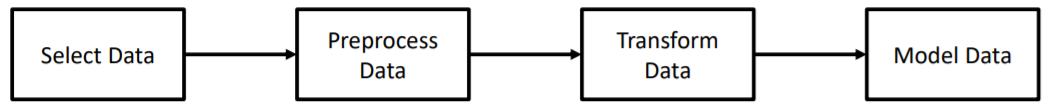

In [3]:
from IPython.display import Image
Image(filename='ML_process.png')

# 1. Select data

We were provided with 2 datasets: 

* training_set.csv
* test_set.csv

Both were part of the Kaggle competition: https://www.kaggle.com/christianlillelund/csgo-round-winner-classification

The dataset consists of ~700 demos from high level tournament play in 2019 and 2020. Warmup rounds and restarts have been filtered, and for the remaining live rounds a round snapshot have been recorded every 20 seconds until the round is decided. Following its initial publication, It has been pre-processed and flattened to improve readability and make it easier for algorithms to process. The total number of snapshots is 122411.

# 2. Preprocess data 

In [4]:
# Import the necessary libraries for the analysis

# Data processing
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport


# Scikit librarie
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif


# For plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
# # To be able to see all the rows
# pd.set_option('max_columns', None)
# pd.set_op tion('display.max_rows', None)

In [6]:
# Loading the csv files

df = pd.read_csv('training_set.csv')
testdf = pd.read_csv('test_set.csv')

In [7]:
df.head(5)

time_left  ct_score  t_score         map  bomb_planted  ct_health  \
0      94.96      11.0      2.0    de_train         False      392.0   
1     175.00      13.0      9.0     de_nuke         False      500.0   
2     175.00      14.0     11.0  de_inferno         False      500.0   
3      74.89      12.0     11.0  de_inferno         False      439.0   
4     110.04       3.0     12.0     de_nuke         False      500.0   

   t_health  ct_armor  t_armor  ct_money  ...  t_grenade_flashbang  \
0     500.0     379.0    500.0   23300.0  ...                  5.0   
1     500.0       0.0    300.0   28150.0  ...                  3.0   
2     500.0     486.0    288.0   11650.0  ...                  3.0   
3     489.0     443.0    434.0    3500.0  ...                  4.0   
4     500.0     500.0    400.0     700.0  ...                  0.0   

   ct_grenade_smokegrenade  t_grenade_smokegrenade  \
0                      2.0                     5.0   
1                      0.0                     2.0   
2                      5.0                     2.0   
3                      4.0                     4.0   
4                      0.0                     0.0   

   ct_grenade_incendiarygrenade  t_grenade_incendiarygrenade  \
0                           1.0                          0.0   
1                           0.0                          0.0   
2                           3.0                          0.0   
3                           3.0                          0.0   
4                           0.0                          0.0   

   ct_grenade_molotovgrenade  t_grenade_molotovgrenade  \
0                        0.0                       3.0   
1                        0.0                       1.0   
2                        1.0                       3.0   
3                        0.0                       1.0   
4                        0.0                       1.0   

   ct_grenade_decoygrenade  t_grenade_decoygrenade  round_winner  
0                      0.0                     1.0            CT  
1                      0.0                     0.0             T  
2                      0.0                     0.0             T  
3                      0.0                     0.0            CT  
4                      0.0                     1.0             T  

[5 rows x 97 columns]

In [8]:
df.shape

(82014, 97)

In [9]:
# To identify the types
df.dtypes

time_left                    float64
ct_score                     float64
t_score                      float64
map                           object
bomb_planted                    bool
                              ...   
ct_grenade_molotovgrenade    float64
t_grenade_molotovgrenade     float64
ct_grenade_decoygrenade      float64
t_grenade_decoygrenade       float64
round_winner                  object
Length: 97, dtype: object

In [10]:
# Converting column 'bomb_planted' into a numeric
df['bomb_planted'] = df['bomb_planted'].astype('float64')

In [11]:
df['bomb_planted'].unique()

array([0., 1.])

In [12]:
# Converting column 'round_winner' into numeric
df['round_winner'].replace(['CT','T'], [0,1], inplace=True)

In [13]:
df['round_winner'].unique()

array([0, 1], dtype=int64)

#### Getting a detailed profiling of the features

In [14]:
# Getting a detailed report of the dataset, as a first 

# reporttrain = ProfileReport(df)

In [15]:
# As we have many features, is better to export the report not to crash 'google chrome'

# reporttrain.to_file("CS_GO_Report.html")

# 3. Transform data 

## Outliers identification and exclusion

In [16]:
# We organize the columns so the single columns are first and the columns that come in "tuples" stay together. e.g. all counter terrorist related column and terrorist related columns

cols_to_order = ['round_winner','time_left', 'map','bomb_planted',  'ct_defuse_kits', 'ct_grenade_flashbang', 't_grenade_flashbang']
new_columns = cols_to_order + (df.columns.drop(cols_to_order).tolist())
df = df[new_columns]

In [17]:
# Create business parameter to flag outliers for each variable; if a value of the variable is higher than this parameter the entire row will be considered an outlier from a business point of view and dropped

parameters_1 = [-1, -1, -1, -1, 5, 10, 10, -1, -1, 500, 500, 500, 500, 80000, 80000] #values fir variables until money
parameters_2 = [5] * 82 #values for all the rest of weapons
parameters = parameters_1 + parameters_2
ser_par = pd.Series(parameters, index = df.columns)

In [18]:
ser_par

round_winner                  -1
time_left                     -1
map                           -1
bomb_planted                  -1
ct_defuse_kits                 5
                              ..
t_grenade_incendiarygrenade    5
ct_grenade_molotovgrenade      5
t_grenade_molotovgrenade       5
ct_grenade_decoygrenade        5
t_grenade_decoygrenade         5
Length: 97, dtype: int64

In [19]:
# To understand for each feature if it has 'outliers' and 'NAs'

results = pd.DataFrame(np.nan, index=df.columns, columns=['Outlier', 'NAs'])

for i, j in enumerate(ser_par):
    if j > 0:
        a = (df[ser_par.index[i]]>j).sum().astype('bool')
        b = df[ser_par.index[i]].isna().sum().astype('bool')
        results.loc[ser_par.index[i], 'Outlier'] = a
        results.loc[ser_par.index[i], 'NAs'] = b  

In [20]:
results

Outlier    NAs
round_winner                    NaN    NaN
time_left                       NaN    NaN
map                             NaN    NaN
bomb_planted                    NaN    NaN
ct_defuse_kits                False  False
...                             ...    ...
t_grenade_incendiarygrenade   False  False
ct_grenade_molotovgrenade     False  False
t_grenade_molotovgrenade      False  False
ct_grenade_decoygrenade       False  False
t_grenade_decoygrenade        False  False

[97 rows x 2 columns]

In [21]:
# Create a dataframe with the number of occurrences for each value for the weapon variables

results2 = pd.DataFrame()


# Subset the columns associated with weapons, grenades and the defuse kit

for i in df.columns[np.r_[4:7, 15:len(df.columns)]]:
    x = df.groupby(i)[i].count()
    results2 = pd.concat([results2, x], axis = 1)


# Calculate the transposed matrix, table of frequencies

results3 = results2.T
results3

0.0      1.0      2.0      3.0      4.0   \
ct_defuse_kits               28212.0  18322.0  11397.0  10354.0   8119.0   
ct_grenade_flashbang         27774.0  14280.0  10883.0  10051.0   9362.0   
t_grenade_flashbang          27602.0  14906.0  10947.0   9189.0   8602.0   
ct_helmets                   25803.0  12181.0  10883.0  10327.0  10414.0   
t_helmets                    20968.0   6115.0   7205.0   9299.0  12865.0   
...                              ...      ...      ...      ...      ...   
t_grenade_incendiarygrenade  80401.0   1570.0     41.0      2.0      NaN   
ct_grenade_molotovgrenade    78338.0   3442.0    225.0      9.0      NaN   
t_grenade_molotovgrenade     39525.0  13196.0   9183.0   7476.0   6264.0   
ct_grenade_decoygrenade      79789.0   2156.0     67.0      2.0      NaN   
t_grenade_decoygrenade       79983.0   1955.0     76.0      NaN      NaN   

                                5.0   6.0   7.0   9.0   10.0  
ct_defuse_kits                5610.0   NaN   NaN   NaN   NaN  
ct_grenade_flashbang          9663.0   1.0   NaN   NaN   NaN  
t_grenade_flashbang          10768.0   NaN   NaN   NaN   NaN  
ct_helmets                   12406.0   NaN   NaN   NaN   NaN  
t_helmets                    25562.0   NaN   NaN   NaN   NaN  
...                              ...   ...   ...   ...   ...  
t_grenade_incendiarygrenade      NaN   NaN   NaN   NaN   NaN  
ct_grenade_molotovgrenade        NaN   NaN   NaN   NaN   NaN  
t_grenade_molotovgrenade      6370.0   NaN   NaN   NaN   NaN  
ct_grenade_decoygrenade          NaN   NaN   NaN   NaN   NaN  
t_grenade_decoygrenade           NaN   NaN   NaN   NaN   NaN  

[85 rows x 10 columns]

Now we will calculate for each row how many columns are not respecting the business rules defined in 'ser_par'.

For that we test versus the Dataframe of True/False 'results'

In [22]:
# Checking vs the business rules 'ser_par'

result4 = pd.DataFrame(index = df.index)

for i, j in enumerate(ser_par):
    if j > 0:
        a = df[ser_par.index[i]] > j
        result4 = pd.concat([result4, a], axis = 1)
    else:
        b = df[ser_par.index[0]] < -1
        b = pd.Series(b, name = ser_par.index[i])
        result4 = pd.concat([result4, b], axis = 1)

In [23]:
# Checking the results

# result4

In [24]:
# Calculate sum by row to sum how many True (outlier = 1) values are present in that row

sum_row = result4.sum(axis = 1)

In [25]:
# Here shows how many rows are going to be dropped from the original df

sum_row[sum_row > 0].count()

15

In [26]:
# Here shows the index of the rows that are going to be dropped

sum_row[sum_row > 0]

9754     2
10420    1
23662    1
23738    1
25697    1
27297    1
40521    2
43406    1
44956    1
46165    2
46347    3
46926    1
55144    1
72303    2
78205    2
dtype: int64

In [27]:
# These are the rows that we need to drop from the dataframe these rows were flag by the 

df.loc[sum_row > 0]

round_winner  time_left         map  bomb_planted  ct_defuse_kits  \
9754              1     175.00   de_mirage           0.0             0.0   
10420             0     175.00    de_dust2           0.0             0.0   
23662             1     175.00     de_nuke           0.0             0.0   
23738             1     169.94    de_dust2           0.0             0.0   
25697             0     175.00   de_mirage           0.0             4.0   
27297             1     175.00   de_mirage           0.0             0.0   
40521             0     175.00  de_inferno           0.0             4.0   
43406             1     170.00    de_dust2           0.0             0.0   
44956             0     175.00   de_mirage           0.0             0.0   
46165             1     175.00     de_nuke           0.0             1.0   
46347             1     175.00  de_vertigo           0.0             0.0   
46926             1     175.00    de_train           0.0             0.0   
55144             1     175.00    de_dust2           0.0             0.0   
72303             1     175.00  de_inferno           0.0             0.0   
78205             0     175.00   de_mirage           0.0             0.0   

       ct_grenade_flashbang  t_grenade_flashbang  ct_score  t_score  \
9754                    2.0                  5.0       9.0     14.0   
10420                   0.0                  0.0      24.0     24.0   
23662                   1.0                  4.0       4.0      5.0   
23738                   0.0                  0.0      15.0     15.0   
25697                   5.0                  0.0       4.0      5.0   
27297                   0.0                  1.0       7.0     12.0   
40521                   6.0                  2.0       7.0      7.0   
43406                   3.0                  3.0      12.0     14.0   
44956                   1.0                  0.0      15.0     15.0   
46165                   1.0                  2.0       2.0      4.0   
46347                   0.0                  0.0       0.0      0.0   
46926                   0.0                  0.0      15.0     15.0   
55144                   0.0                  4.0      14.0     13.0   
72303                   0.0                  3.0       1.0      1.0   
78205                   2.0                  0.0       1.0      0.0   

       ct_health  ...  ct_grenade_hegrenade  t_grenade_hegrenade  \
9754       500.0  ...                   1.0                  0.0   
10420      500.0  ...                   0.0                  0.0   
23662      500.0  ...                   0.0                  2.0   
23738      500.0  ...                   0.0                  0.0   
25697      500.0  ...                   3.0                  0.0   
27297      500.0  ...                   0.0                  0.0   
40521      500.0  ...                   4.0                  1.0   
43406      500.0  ...                   0.0                  0.0   
44956      500.0  ...                   0.0                  0.0   
46165      500.0  ...                   0.0                  3.0   
46347      400.0  ...                   0.0                  0.0   
46926      500.0  ...                   0.0                  0.0   
55144      500.0  ...                   0.0                  2.0   
72303      500.0  ...                   0.0                  0.0   
78205      500.0  ...                   1.0                  0.0   

       ct_grenade_smokegrenade  t_grenade_smokegrenade  \
9754                       0.0                     4.0   
10420                      1.0                     0.0   
23662                      2.0                     3.0   
23738                      0.0                     0.0   
25697                      4.0                     0.0   
27297                      0.0                     1.0   
40521                      3.0                     3.0   
43406                      1.0                     3.0   
44956                      2.0            

These are the rows that we will keep in the dataframe.

In [28]:
df = df.loc[sum_row == 0].reset_index(drop=True)
df.head(5)

round_winner  time_left         map  bomb_planted  ct_defuse_kits  \
0             0      94.96    de_train           0.0             4.0   
1             1     175.00     de_nuke           0.0             0.0   
2             1     175.00  de_inferno           0.0             3.0   
3             0      74.89  de_inferno           0.0             4.0   
4             1     110.04     de_nuke           0.0             0.0   

   ct_grenade_flashbang  t_grenade_flashbang  ct_score  t_score  ct_health  \
0                   3.0                  5.0      11.0      2.0      392.0   
1                   0.0                  3.0      13.0      9.0      500.0   
2                   5.0                  3.0      14.0     11.0      500.0   
3                   4.0                  4.0      12.0     11.0      439.0   
4                   0.0                  0.0       3.0     12.0      500.0   

   ...  ct_grenade_hegrenade  t_grenade_hegrenade  ct_grenade_smokegrenade  \
0  ...                   0.0                  0.0                      2.0   
1  ...                   0.0                  1.0                      0.0   
2  ...                   4.0                  1.0                      5.0   
3  ...                   1.0                  1.0                      4.0   
4  ...                   0.0                  0.0                      0.0   

   t_grenade_smokegrenade  ct_grenade_incendiarygrenade  \
0                     5.0                           1.0   
1                     2.0                           0.0   
2                     2.0                           3.0   
3                     4.0                           3.0   
4                     0.0                           0.0   

   t_grenade_incendiarygrenade  ct_grenade_molotovgrenade  \
0                          0.0                        0.0   
1                          0.0                        0.0   
2                          0.0                        1.0   
3                          0.0                        0.0   
4                          0.0                        0.0   

   t_grenade_molotovgrenade  ct_grenade_decoygrenade  t_grenade_decoygrenade  
0                       3.0                      0.0                     1.0  
1                       1.0                      0.0                     0.0  
2                       3.0                      0.0                     0.0  
3                       1.0                      0.0                     0.0  
4                       1.0                      0.0                     1.0  

[5 rows x 97 columns]

In [29]:
# Original dataframe shape               = (82014, 97)
# New dataframe without 'outliers' shape = (81999, 97)
# The difference = 15 , are the rows that had outliers in one or more columns

df.shape

(81999, 97)

## Feature Engineering

In [30]:
df.head(5)

round_winner  time_left         map  bomb_planted  ct_defuse_kits  \
0             0      94.96    de_train           0.0             4.0   
1             1     175.00     de_nuke           0.0             0.0   
2             1     175.00  de_inferno           0.0             3.0   
3             0      74.89  de_inferno           0.0             4.0   
4             1     110.04     de_nuke           0.0             0.0   

   ct_grenade_flashbang  t_grenade_flashbang  ct_score  t_score  ct_health  \
0                   3.0                  5.0      11.0      2.0      392.0   
1                   0.0                  3.0      13.0      9.0      500.0   
2                   5.0                  3.0      14.0     11.0      500.0   
3                   4.0                  4.0      12.0     11.0      439.0   
4                   0.0                  0.0       3.0     12.0      500.0   

   ...  ct_grenade_hegrenade  t_grenade_hegrenade  ct_grenade_smokegrenade  \
0  ...                   0.0                  0.0                      2.0   
1  ...                   0.0                  1.0                      0.0   
2  ...                   4.0                  1.0                      5.0   
3  ...                   1.0                  1.0                      4.0   
4  ...                   0.0                  0.0                      0.0   

   t_grenade_smokegrenade  ct_grenade_incendiarygrenade  \
0                     5.0                           1.0   
1                     2.0                           0.0   
2                     2.0                           3.0   
3                     4.0                           3.0   
4                     0.0                           0.0   

   t_grenade_incendiarygrenade  ct_grenade_molotovgrenade  \
0                          0.0                        0.0   
1                          0.0                        0.0   
2                          0.0                        1.0   
3                          0.0                        0.0   
4                          0.0                        0.0   

   t_grenade_molotovgrenade  ct_grenade_decoygrenade  t_grenade_decoygrenade  
0                       3.0                      0.0                     1.0  
1                       1.0                      0.0                     0.0  
2                       3.0                      0.0                     0.0  
3                       1.0                      0.0                     0.0  
4                       1.0                      0.0                     1.0  

[5 rows x 97 columns]

In order to understand the impact of the different features towards predicting the target variable, we analyized the correlation between features of the same 'type' of column and their difference.
Then we plotted everything into a Heatmap for each 'type' of columns

Conclusion: 
   * Overall the heatmaps, show that the impact of the difference or 'delta' is more relevant to predict the target variable than the original features by themselves
   * The delta features seems promising, but further analysis need to be done before modeling

e.g. Columns health: ct_health = -0.19, t_health = 0.09, delta_health = -0.4 // 0 = counter terrorist, 1 = terrorist

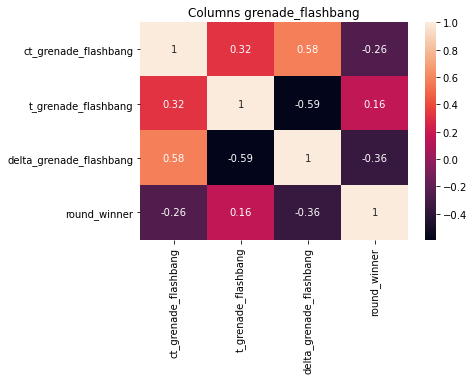

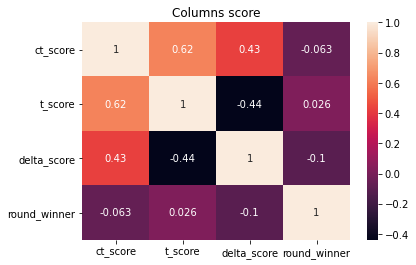

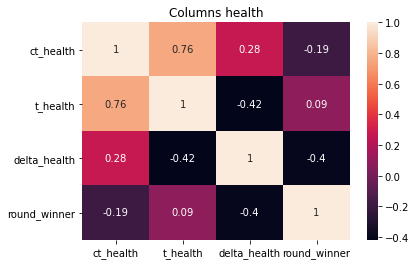

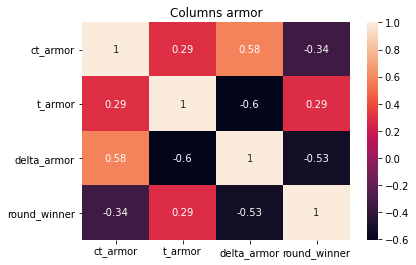

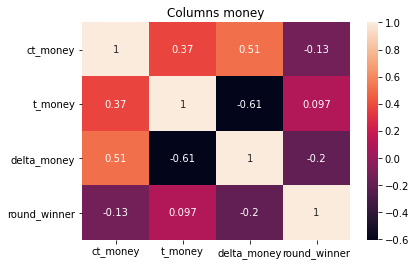

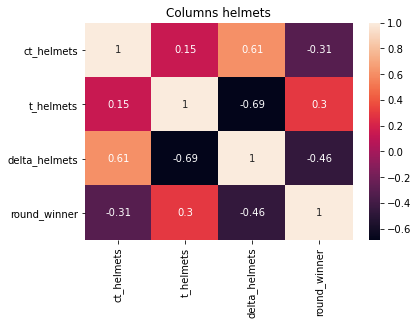

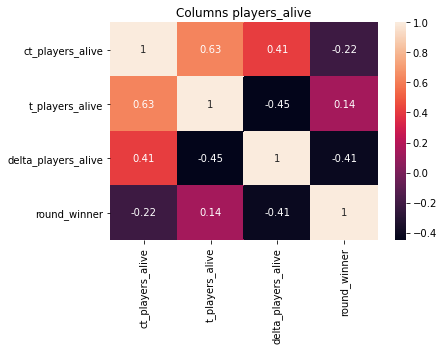

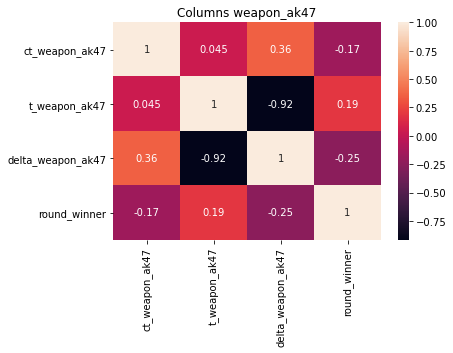

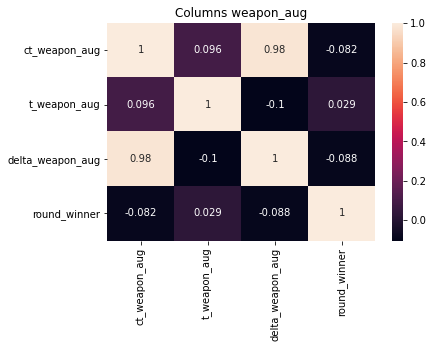

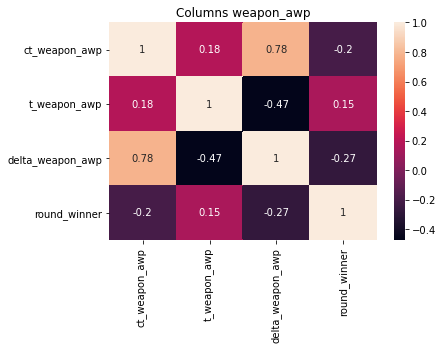

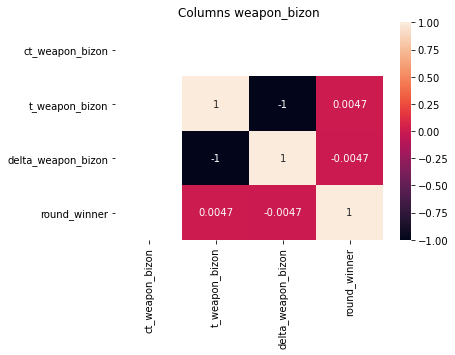

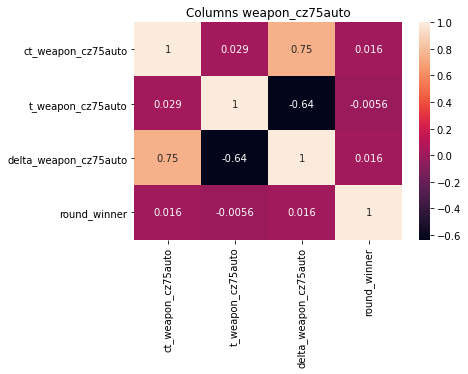

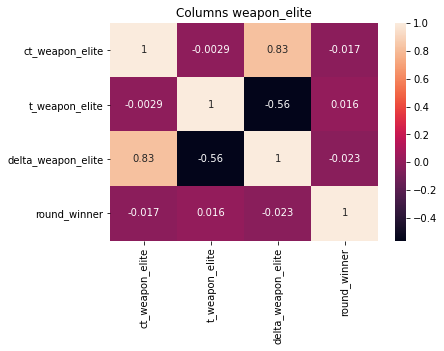

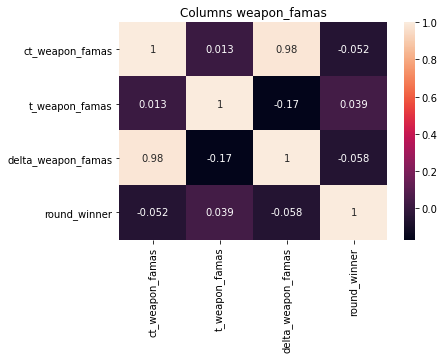

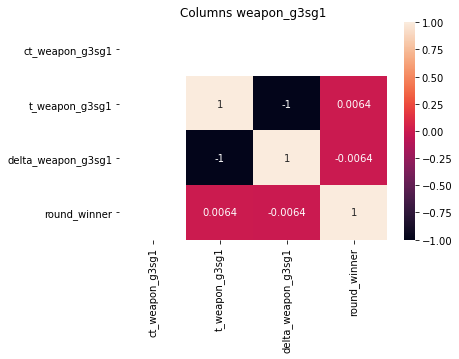

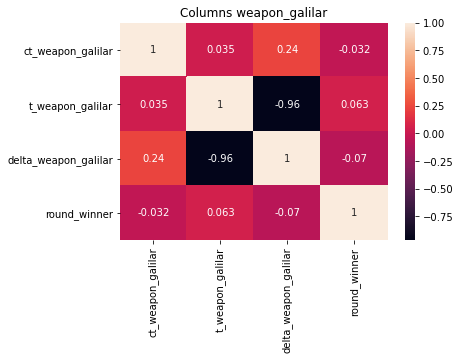

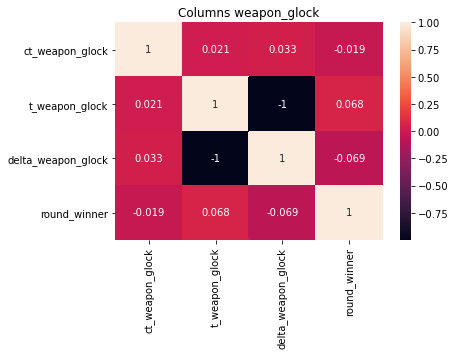

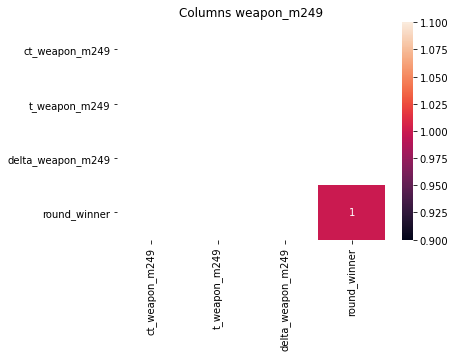

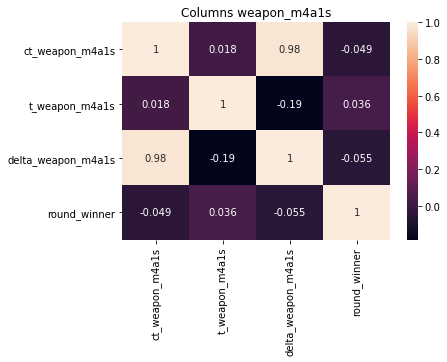

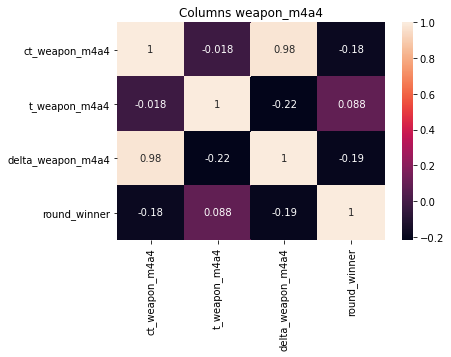

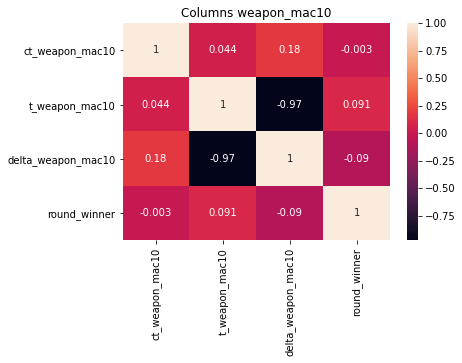

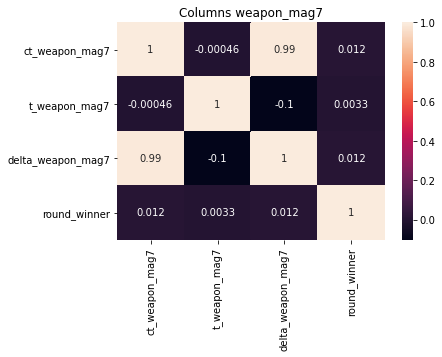

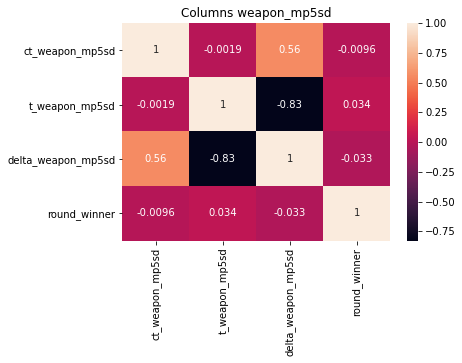

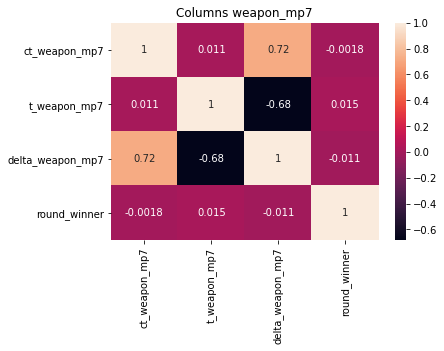

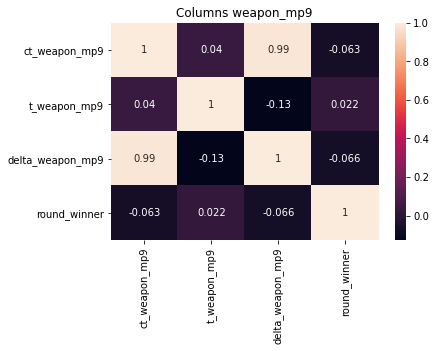

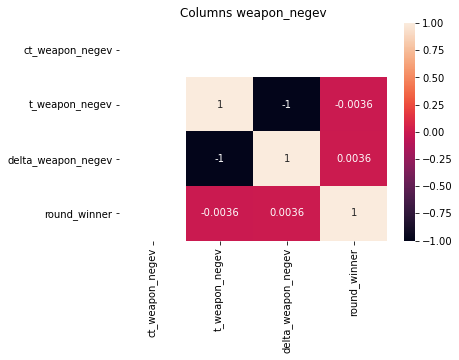

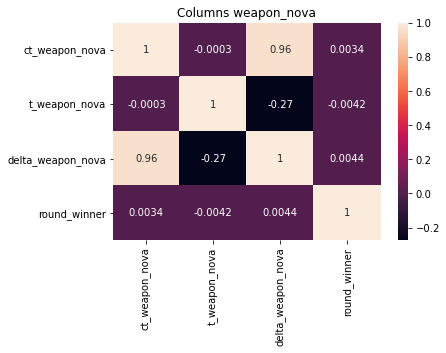

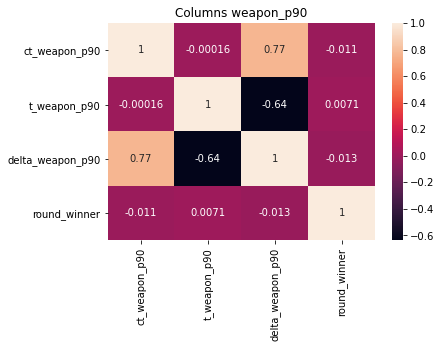

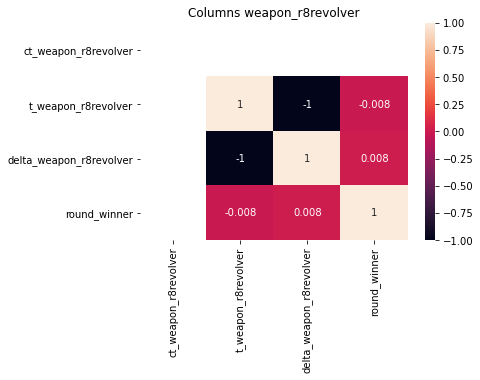

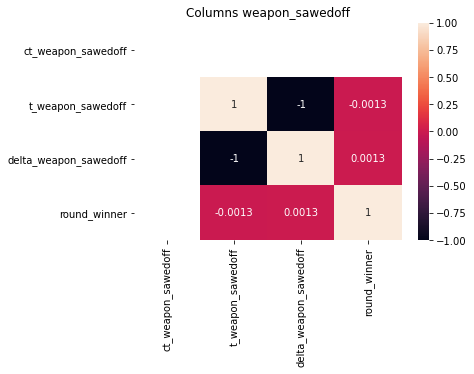

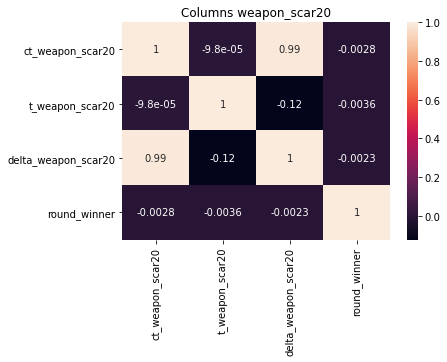

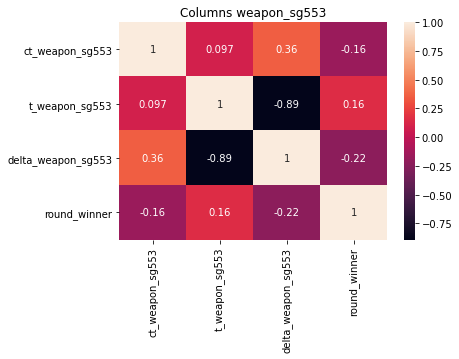

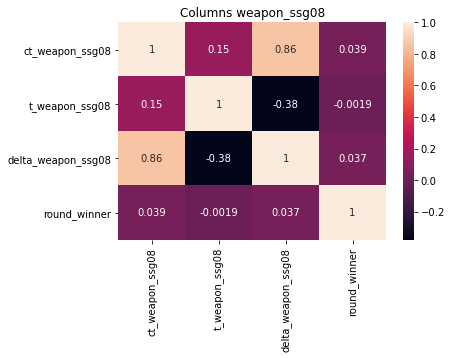

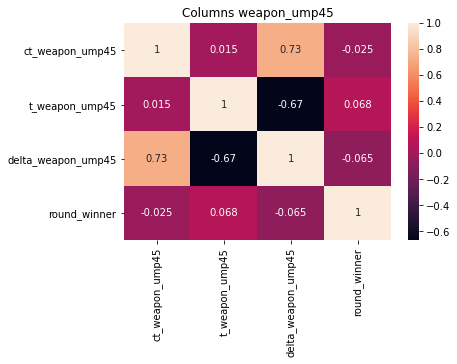

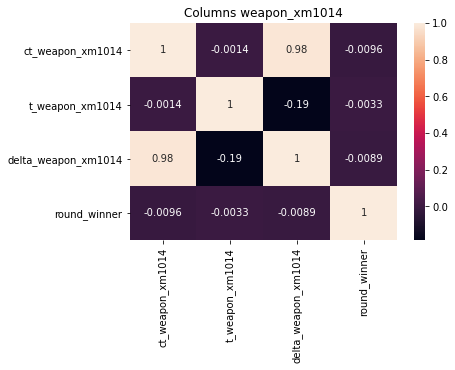

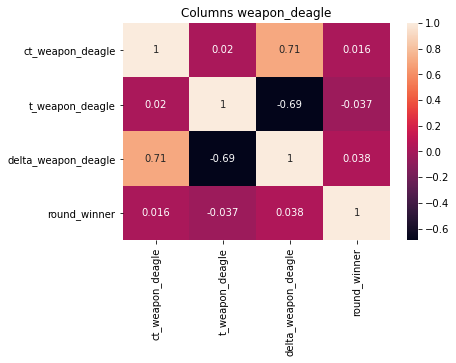

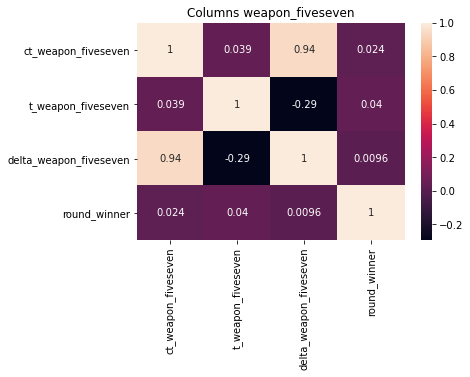

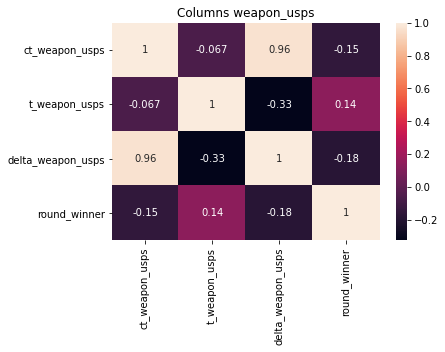

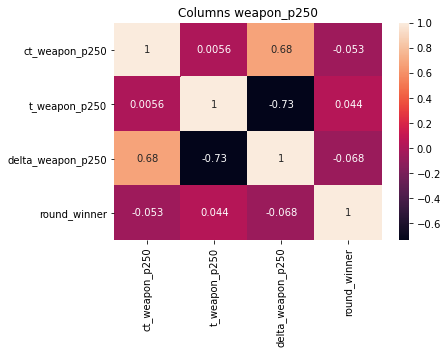

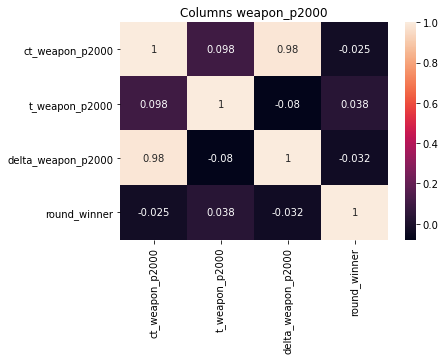

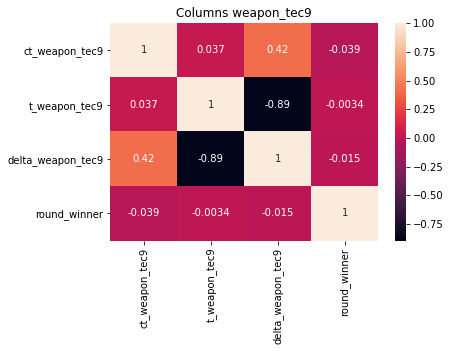

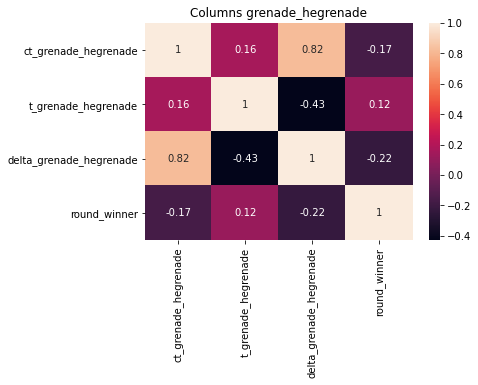

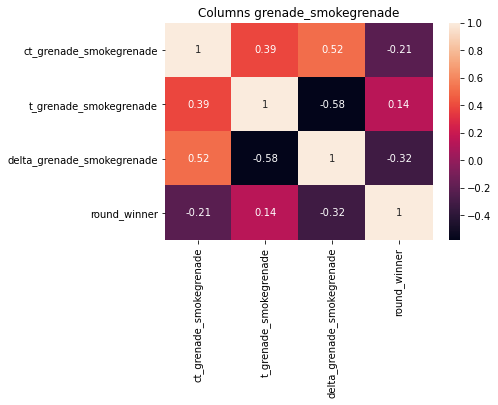

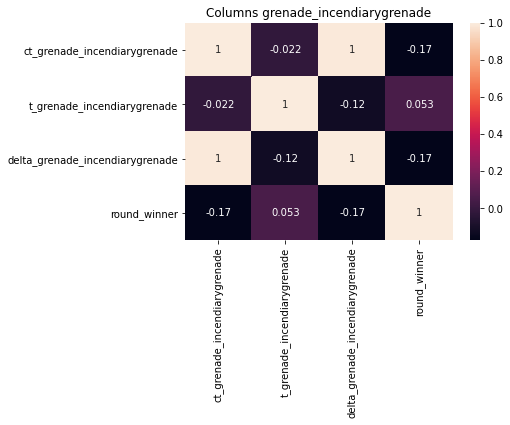

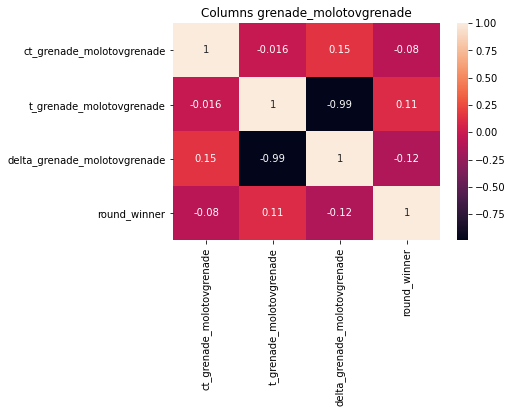

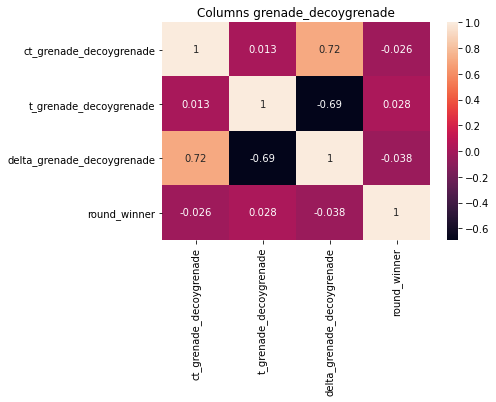

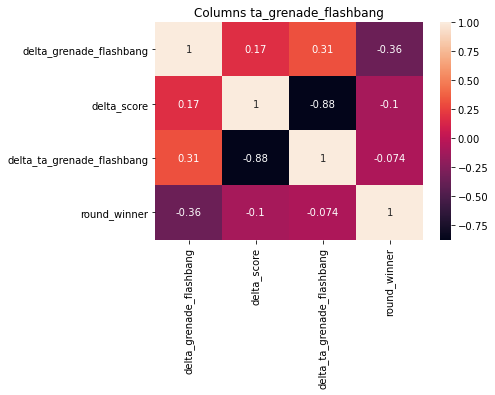

In [31]:
# First we subset the first columns of the dataset to run the profile

df_1 = df.copy()
corr_df = pd.DataFrame(columns = ['Var_name','Target_variable'])
delta_df = pd.DataFrame(df.iloc[:,0:5])

i = 5

# we create the delta columns
while i < (len(df.columns) + 1):
    
    a = df_1.iloc[:,i]
    b = df_1.iloc[:,i+1]
    df_1['delta_'+df_1.iloc[:,i].name[3:]] = a - b
    c = df_1['round_winner']
    
    delta_df['delta_'+df_1.iloc[:,i].name[3:]] = a - b
    corr = df_1[[a.name, b.name,'delta_'+df_1.iloc[:,i].name[3:]]].corrwith(c)
    corr_df = corr_df.append({'Var_name':a.name,'Target_variable':corr[0]}, ignore_index=True)
    corr_df = corr_df.append({'Var_name':b.name,'Target_variable':corr[1]}, ignore_index=True)
    corr_df = corr_df.append({'Var_name':'delta_'+df_1.iloc[:,i].name[3:],'Target_variable':corr[2]}, ignore_index=True)

    corr = df_1[[a.name, b.name,'delta_'+df_1.iloc[:,i].name[3:],'round_winner']].corr()
    sns.heatmap(corr, annot = True)
    plt.title('Columns '+df_1.iloc[:,i].name[3:])
    plt.show()
    i = i + 2

del(corr)

We are going to create some columns based on the weapon category. We will follow the next steps:

   1. Obtain a weapons dataframe, with the categories of each weapon of the game
   2. Create 2 new columns corresponding to the names of the columns in the pre-processed 'df', to match coincidences
   3. Create 3 additional dataframes:
       3.1 showing the sum of weapons per category for both ct and t
       3.2 showing the avg of weapons per category for both ct and t
       3.2 showing the difference per weapon category between ct and t

In [32]:
# 1. we import the dataframe containing the weapons category description

cat_df = pd.read_csv('WeaponCategory.csv')

In [33]:
# Check the dataframe of weapons

cat_df

Weapon_name Category
0                weapon_elite     None
1                  weapon_awp    Rifle
2           weapon_r8revolver   Pistol
3                weapon_ssg08    Rifle
4                 weapon_mag7    Heavy
5                 weapon_nova    Heavy
6               weapon_scar20    Rifle
7                weapon_g3sg1    Rifle
8             weapon_sawedoff    Heavy
9               weapon_xm1014    Heavy
10              weapon_deagle   Pistol
11                weapon_ak47    Rifle
12                weapon_tec9   Pistol
13                weapon_p250   Pistol
14           weapon_fiveseven   Pistol
15            weapon_cz75auto   Pistol
16               weapon_sg553    Rifle
17               weapon_negev    Heavy
18                weapon_m249    Heavy
19                weapon_m4a4    Rifle
20               weapon_m4a1s    Rifle
21               weapon_ump45     SMGs
22                weapon_usps   Pistol
23               weapon_p2000   Pistol
24             weapon_galilar    Rifle
25                 weapon_aug    Rifle
26               weapon_famas    Rifle
27                 weapon_mp7     SMGs
28               weapon_mp5sd     SMGs
29               weapon_mac10     SMGs
30                 weapon_p90     SMGs
31               weapon_glock   Pistol
32               weapon_bizon     SMGs
33                 weapon_mp9     SMGs
34          grenade_hegrenade  Grenade
35          grenade_flashbang  Grenade
36       grenade_smokegrenade  Grenade
37  grenade_incendiarygrenade  Grenade
38     grenade_molotovgrenade  Grenade
39       grenade_decoygrenade  Grenade

In [34]:
# 2. Create 2 new columns corresponding to the names of the columns in df, so we can have a correspondence 

cat_df['ct_cols'] = "ct_" + cat_df['Weapon_name'] 
cat_df['t_cols'] = "t_" + cat_df['Weapon_name'] 

In [35]:
# 3. create 3 dataframes: 
#   3.1 showing the sum of weapons per category for both ct and t
#   3.2 showing the avg of weapons per category for both ct and t
#   3.2 showing the difference per weapon category between ct and t 

weapcat_sum_df = pd.DataFrame(df.iloc[:,np.r_[0:5, 7:19]])
weapcat_avg_df = pd.DataFrame(df.iloc[:,np.r_[0:5, 7:19]])
weapcat_deltas_df = pd.DataFrame(delta_df.iloc[:,np.r_[0:5, 6:12]])
weapcat_deltaa_df = pd.DataFrame(delta_df.iloc[:,np.r_[0:5, 6:12]])

for i in cat_df['Category'].unique():
    #print(i)
    ct = df[cat_df[cat_df['Category']==i]['ct_cols']]
    t = df[cat_df[cat_df['Category']==i]['t_cols']]
    
    weapcat_sum_df['ct_'+i] = ct.sum(axis=1)
    weapcat_sum_df['t_'+i] = t.sum(axis=1)
    weapcat_avg_df['ct_'+i] = ct.mean(axis=1)
    weapcat_avg_df['t_'+i] = t.mean(axis=1)
    
    weapcat_deltas_df['dlt_'+i] = ct.sum(axis=1) -t.sum(axis=1)
    weapcat_deltaa_df['dlt_'+i] = ct.mean(axis=1) -t.mean(axis=1)
    
del(cat_df,ct, t)

In [36]:
weapcat_deltas_df.head(2)

round_winner  time_left       map  bomb_planted  ct_defuse_kits  \
0             0      94.96  de_train           0.0             4.0   
1             1     175.00   de_nuke           0.0             0.0   

   delta_score  delta_health  delta_armor  delta_money  delta_helmets  \
0          9.0        -108.0       -121.0      20800.0           -1.0   
1          4.0           0.0       -300.0     -16200.0           -4.0   

   delta_players_alive  dlt_None  dlt_Rifle  dlt_Pistol  dlt_Heavy  dlt_SMGs  \
0                 -1.0       0.0        0.0        -1.0        0.0      -1.0   
1                  0.0       0.0       -4.0         0.0        0.0       0.0   

   dlt_Grenade  
0         -8.0  
1         -7.0

In [37]:
weapcat_sum_df.head(2)

round_winner  time_left       map  bomb_planted  ct_defuse_kits  ct_score  \
0             0      94.96  de_train           0.0             4.0      11.0   
1             1     175.00   de_nuke           0.0             0.0      13.0   

   t_score  ct_health  t_health  ct_armor  ...  ct_Rifle  t_Rifle  ct_Pistol  \
0      2.0      392.0     500.0     379.0  ...       4.0      4.0        4.0   
1      9.0      500.0     500.0       0.0  ...       0.0      4.0        5.0   

   t_Pistol  ct_Heavy  t_Heavy  ct_SMGs  t_SMGs  ct_Grenade  t_Grenade  
0       5.0       0.0      0.0      0.0     1.0         6.0       14.0  
1       5.0       0.0      0.0      0.0     0.0         0.0        7.0  

[2 rows x 29 columns]

In [38]:
weapcat_avg_df.head(2)

round_winner  time_left       map  bomb_planted  ct_defuse_kits  ct_score  \
0             0      94.96  de_train           0.0             4.0      11.0   
1             1     175.00   de_nuke           0.0             0.0      13.0   

   t_score  ct_health  t_health  ct_armor  ...  ct_Rifle   t_Rifle  ct_Pistol  \
0      2.0      392.0     500.0     379.0  ...  0.363636  0.363636   0.444444   
1      9.0      500.0     500.0       0.0  ...  0.000000  0.363636   0.555556   

   t_Pistol  ct_Heavy  t_Heavy  ct_SMGs    t_SMGs  ct_Grenade  t_Grenade  
0  0.555556       0.0      0.0      0.0  0.142857         1.0   2.333333  
1  0.555556       0.0      0.0      0.0  0.000000         0.0   1.166667  

[2 rows x 29 columns]

In [39]:
# Utilize the 'mutual_info_classif' to obtain information about predictivity power of the feature regarding the target variable

mi = mutual_info_classif(df.drop(["round_winner", "map"], axis=1), df.round_winner)
mi_df = pd.DataFrame(mi,index=df.iloc[:,np.r_[1, 3:len(df.columns)]].columns, columns =['mi_score'])

In [40]:
# Checking the results, of those features that have a mi > 5%

mi_df[mi_df['mi_score']>0.05].sort_values(by='mi_score', ascending=False)

mi_score
t_armor         0.080719
ct_armor        0.071703
ct_defuse_kits  0.051963
t_helmets       0.050431

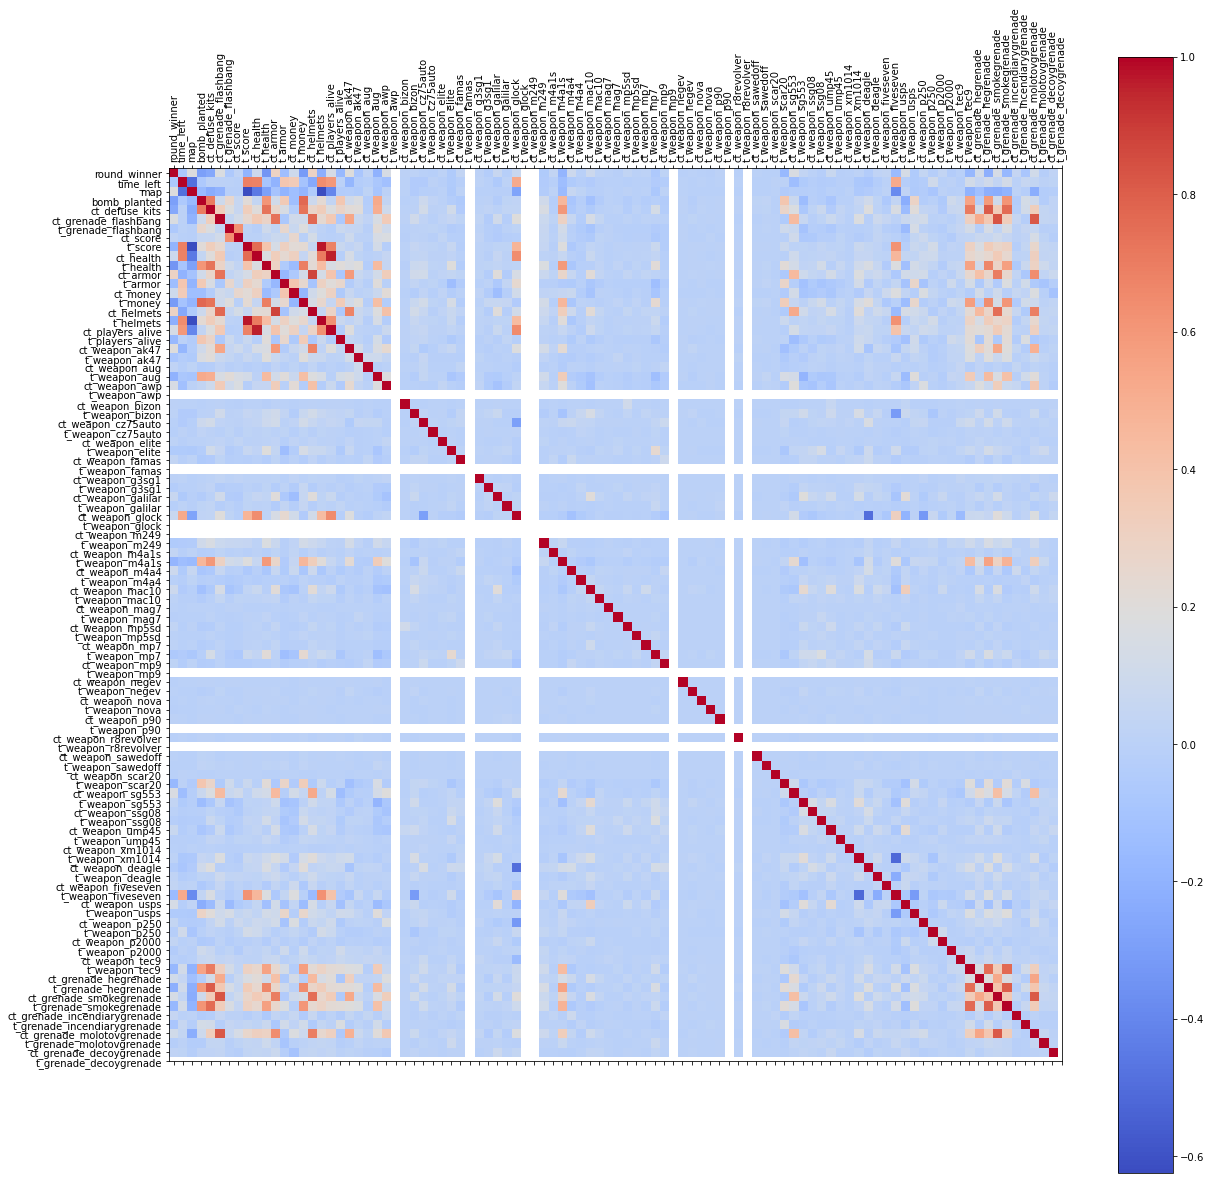

In [41]:
# Reviewing the correlations with a Matrix

f = plt.figure(figsize=(20, 20))
plt.matshow(df.corr(), fignum=f.number, cmap=plt.cm.coolwarm)
plt.xticks(range(df.shape[1]), df.columns, fontsize=10, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

In [42]:
# Checking the 'mi' of the new dataframe with deltas 'mi_dlt_df', with 'mi'>5%

mi_delta = mutual_info_classif(delta_df.drop(["round_winner", "map"], axis=1), delta_df.round_winner)
mi_dlt_df = pd.DataFrame(mi_delta,index=delta_df.iloc[:,np.r_[1, 3:len(delta_df.columns)]].columns, columns =['mi_score'])
mi_dlt_df[mi_dlt_df['mi_score']>0.05].sort_values(by='mi_score', ascending=False)

mi_score
delta_armor                 0.188724
delta_helmets               0.122081
delta_players_alive         0.110091
delta_health                0.105324
delta_grenade_flashbang     0.070437
delta_grenade_smokegrenade  0.053691
ct_defuse_kits              0.051141

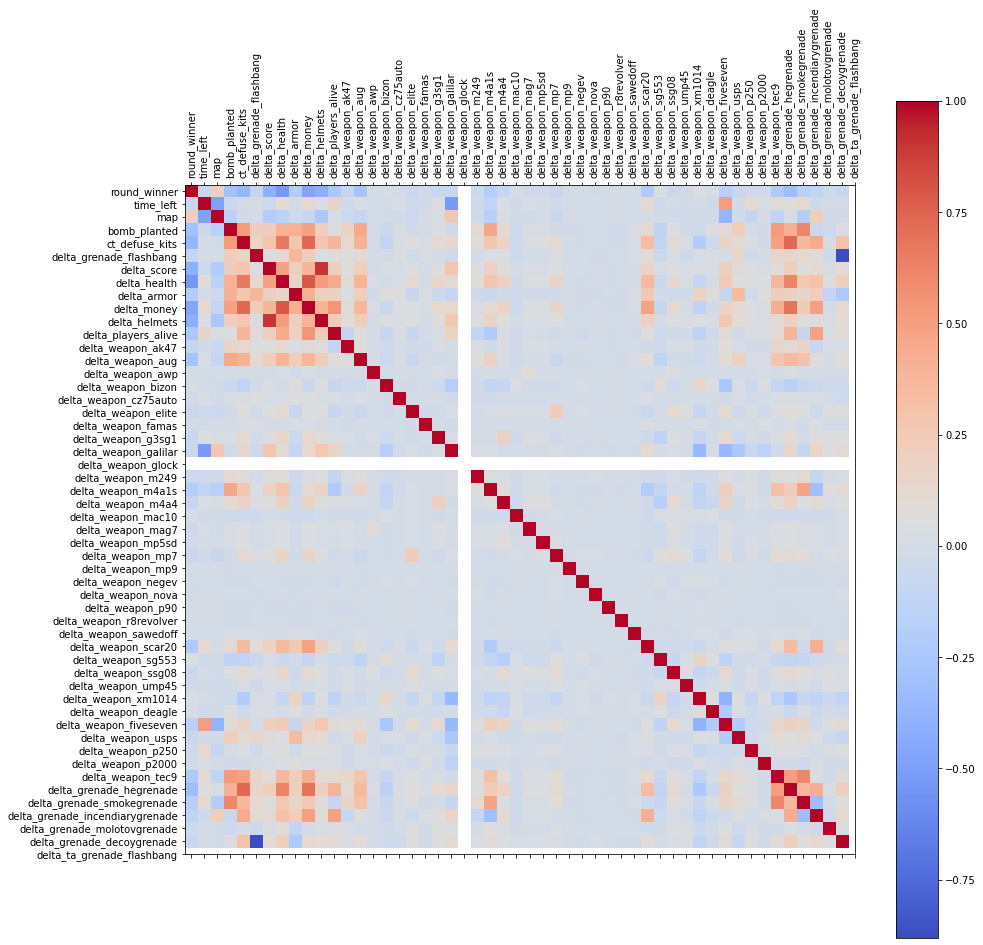

In [43]:
# Plot the correlations matrix of the deltas 'mi_dlt_df'

f = plt.figure(figsize=(15, 15))
plt.matshow(delta_df.corr(), fignum=f.number, cmap=plt.cm.coolwarm)
plt.xticks(range(delta_df.shape[1]), delta_df.columns, fontsize=10, rotation=90)
plt.yticks(range(delta_df.shape[1]), delta_df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

As we can see, the new deltas matrix has better features, in the term of predicting power

In [44]:
# Now we will check the 'mi' of the matrix: mi_wc_sum_df

mi_wc_sum = mutual_info_classif(weapcat_sum_df.drop(["round_winner", "map"], axis=1), weapcat_sum_df.round_winner)
mi_wc_sum_df = pd.DataFrame(mi_wc_sum,index=weapcat_sum_df.iloc[:,np.r_[1, 3:len(weapcat_sum_df.columns)]].columns, columns =['mi_score'])
mi_wc_sum_df[mi_wc_sum_df['mi_score']>0.05].sort_values(by='mi_score', ascending=False)

mi_score
t_armor         0.083390
ct_armor        0.074491
ct_Rifle        0.058493
t_Rifle         0.056377
t_helmets       0.052444
ct_helmets      0.052429
ct_defuse_kits  0.051138

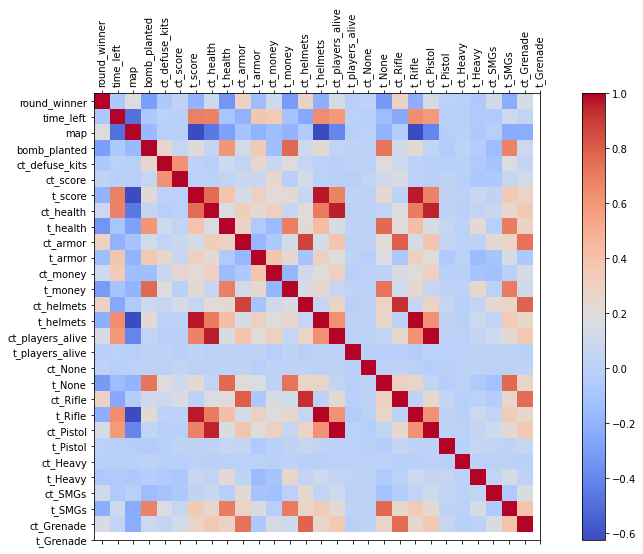

In [45]:
# Again, plotting the correlations matrix for easy visualizing

f = plt.figure(figsize=(15, 8))
plt.matshow(weapcat_sum_df.corr(), fignum=f.number, cmap=plt.cm.coolwarm)
plt.xticks(range(weapcat_sum_df.shape[1]), weapcat_sum_df.columns, fontsize=10, rotation=90)
plt.yticks(range(weapcat_sum_df.shape[1]), weapcat_sum_df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

In [46]:
# Same procedure to check 'mi' of the matrix: mi_wc_deltaa_df

mi_wc_deltaa = mutual_info_classif(weapcat_deltaa_df.drop(["round_winner", "map"], axis=1), weapcat_deltaa_df.round_winner)
mi_wc_deltaa_df = pd.DataFrame(mi_wc_deltaa,index=weapcat_deltaa_df.iloc[:,np.r_[1, 3:len(weapcat_deltaa_df.columns)]].columns, columns =['mi_score'])
mi_wc_deltaa_df[mi_wc_deltaa_df['mi_score']>0.05].sort_values(by='mi_score', ascending=False)

mi_score
delta_armor          0.189431
dlt_Rifle            0.156115
delta_helmets        0.124970
delta_players_alive  0.112082
dlt_Pistol           0.107802
delta_health         0.105097
dlt_Grenade          0.069443
ct_defuse_kits       0.053187

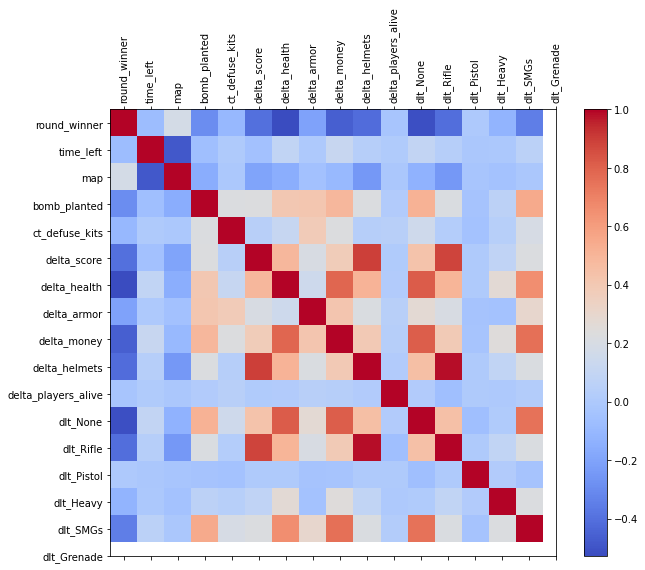

In [47]:
# Visualizing the correlation matrix

f = plt.figure(figsize=(10, 8))
plt.matshow(weapcat_deltaa_df.corr(), fignum=f.number, cmap=plt.cm.coolwarm)
plt.xticks(range(weapcat_deltaa_df.shape[1]), weapcat_deltaa_df.columns, fontsize=10, rotation=90)
plt.yticks(range(weapcat_deltaa_df.shape[1]), weapcat_deltaa_df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

In [48]:
# Again with 'mi_wc_deltas_df'

mi_wc_deltas = mutual_info_classif(weapcat_deltas_df.drop(["round_winner", "map"], axis=1), weapcat_deltas_df.round_winner)
mi_wc_deltas_df = pd.DataFrame(mi_wc_deltas,index=weapcat_deltas_df.iloc[:,np.r_[1, 3:len(weapcat_deltas_df.columns)]].columns, columns =['mi_score'])
mi_wc_deltas_df[mi_wc_deltas_df['mi_score']>0.05].sort_values(by='mi_score', ascending=False)

mi_score
delta_armor          0.190011
dlt_Rifle            0.159117
delta_helmets        0.125855
delta_players_alive  0.110756
dlt_Pistol           0.107297
delta_health         0.104527
dlt_Grenade          0.075110
ct_defuse_kits       0.051251

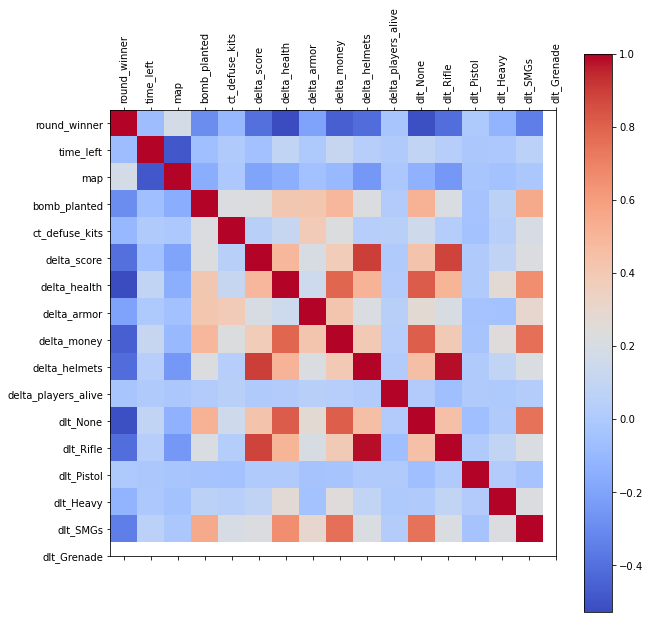

In [49]:
# Visualizing correlation matrix of 'mi_wc_deltas_df'

f = plt.figure(figsize=(10, 10))
plt.matshow(weapcat_deltas_df.corr(), fignum=f.number, cmap=plt.cm.coolwarm)
plt.xticks(range(weapcat_deltas_df.shape[1]), weapcat_deltas_df.columns, fontsize=10, rotation=90)
plt.yticks(range(weapcat_deltas_df.shape[1]), weapcat_deltas_df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

In [50]:
weapcat_deltas_df.shape

(81999, 17)

In [51]:
weapcat_deltas_df.head()

round_winner  time_left         map  bomb_planted  ct_defuse_kits  \
0             0      94.96    de_train           0.0             4.0   
1             1     175.00     de_nuke           0.0             0.0   
2             1     175.00  de_inferno           0.0             3.0   
3             0      74.89  de_inferno           0.0             4.0   
4             1     110.04     de_nuke           0.0             0.0   

   delta_score  delta_health  delta_armor  delta_money  delta_helmets  \
0          9.0        -108.0       -121.0      20800.0           -1.0   
1          4.0           0.0       -300.0     -16200.0           -4.0   
2          3.0           0.0        198.0       4400.0            2.0   
3          1.0         -50.0          9.0      -5650.0           -2.0   
4         -9.0           0.0        100.0         50.0            0.0   

   delta_players_alive  dlt_None  dlt_Rifle  dlt_Pistol  dlt_Heavy  dlt_SMGs  \
0                 -1.0       0.0        0.0        -1.0        0.0      -1.0   
1                  0.0       0.0       -4.0         0.0        0.0       0.0   
2                  0.0       0.0        2.0         0.0        0.0       0.0   
3                  0.0       0.0       -1.0         0.0        0.0       1.0   
4                  0.0       0.0        0.0         0.0        0.0       0.0   

   dlt_Grenade  
0         -8.0  
1         -7.0  
2          9.0  
3          2.0  
4         -2.0

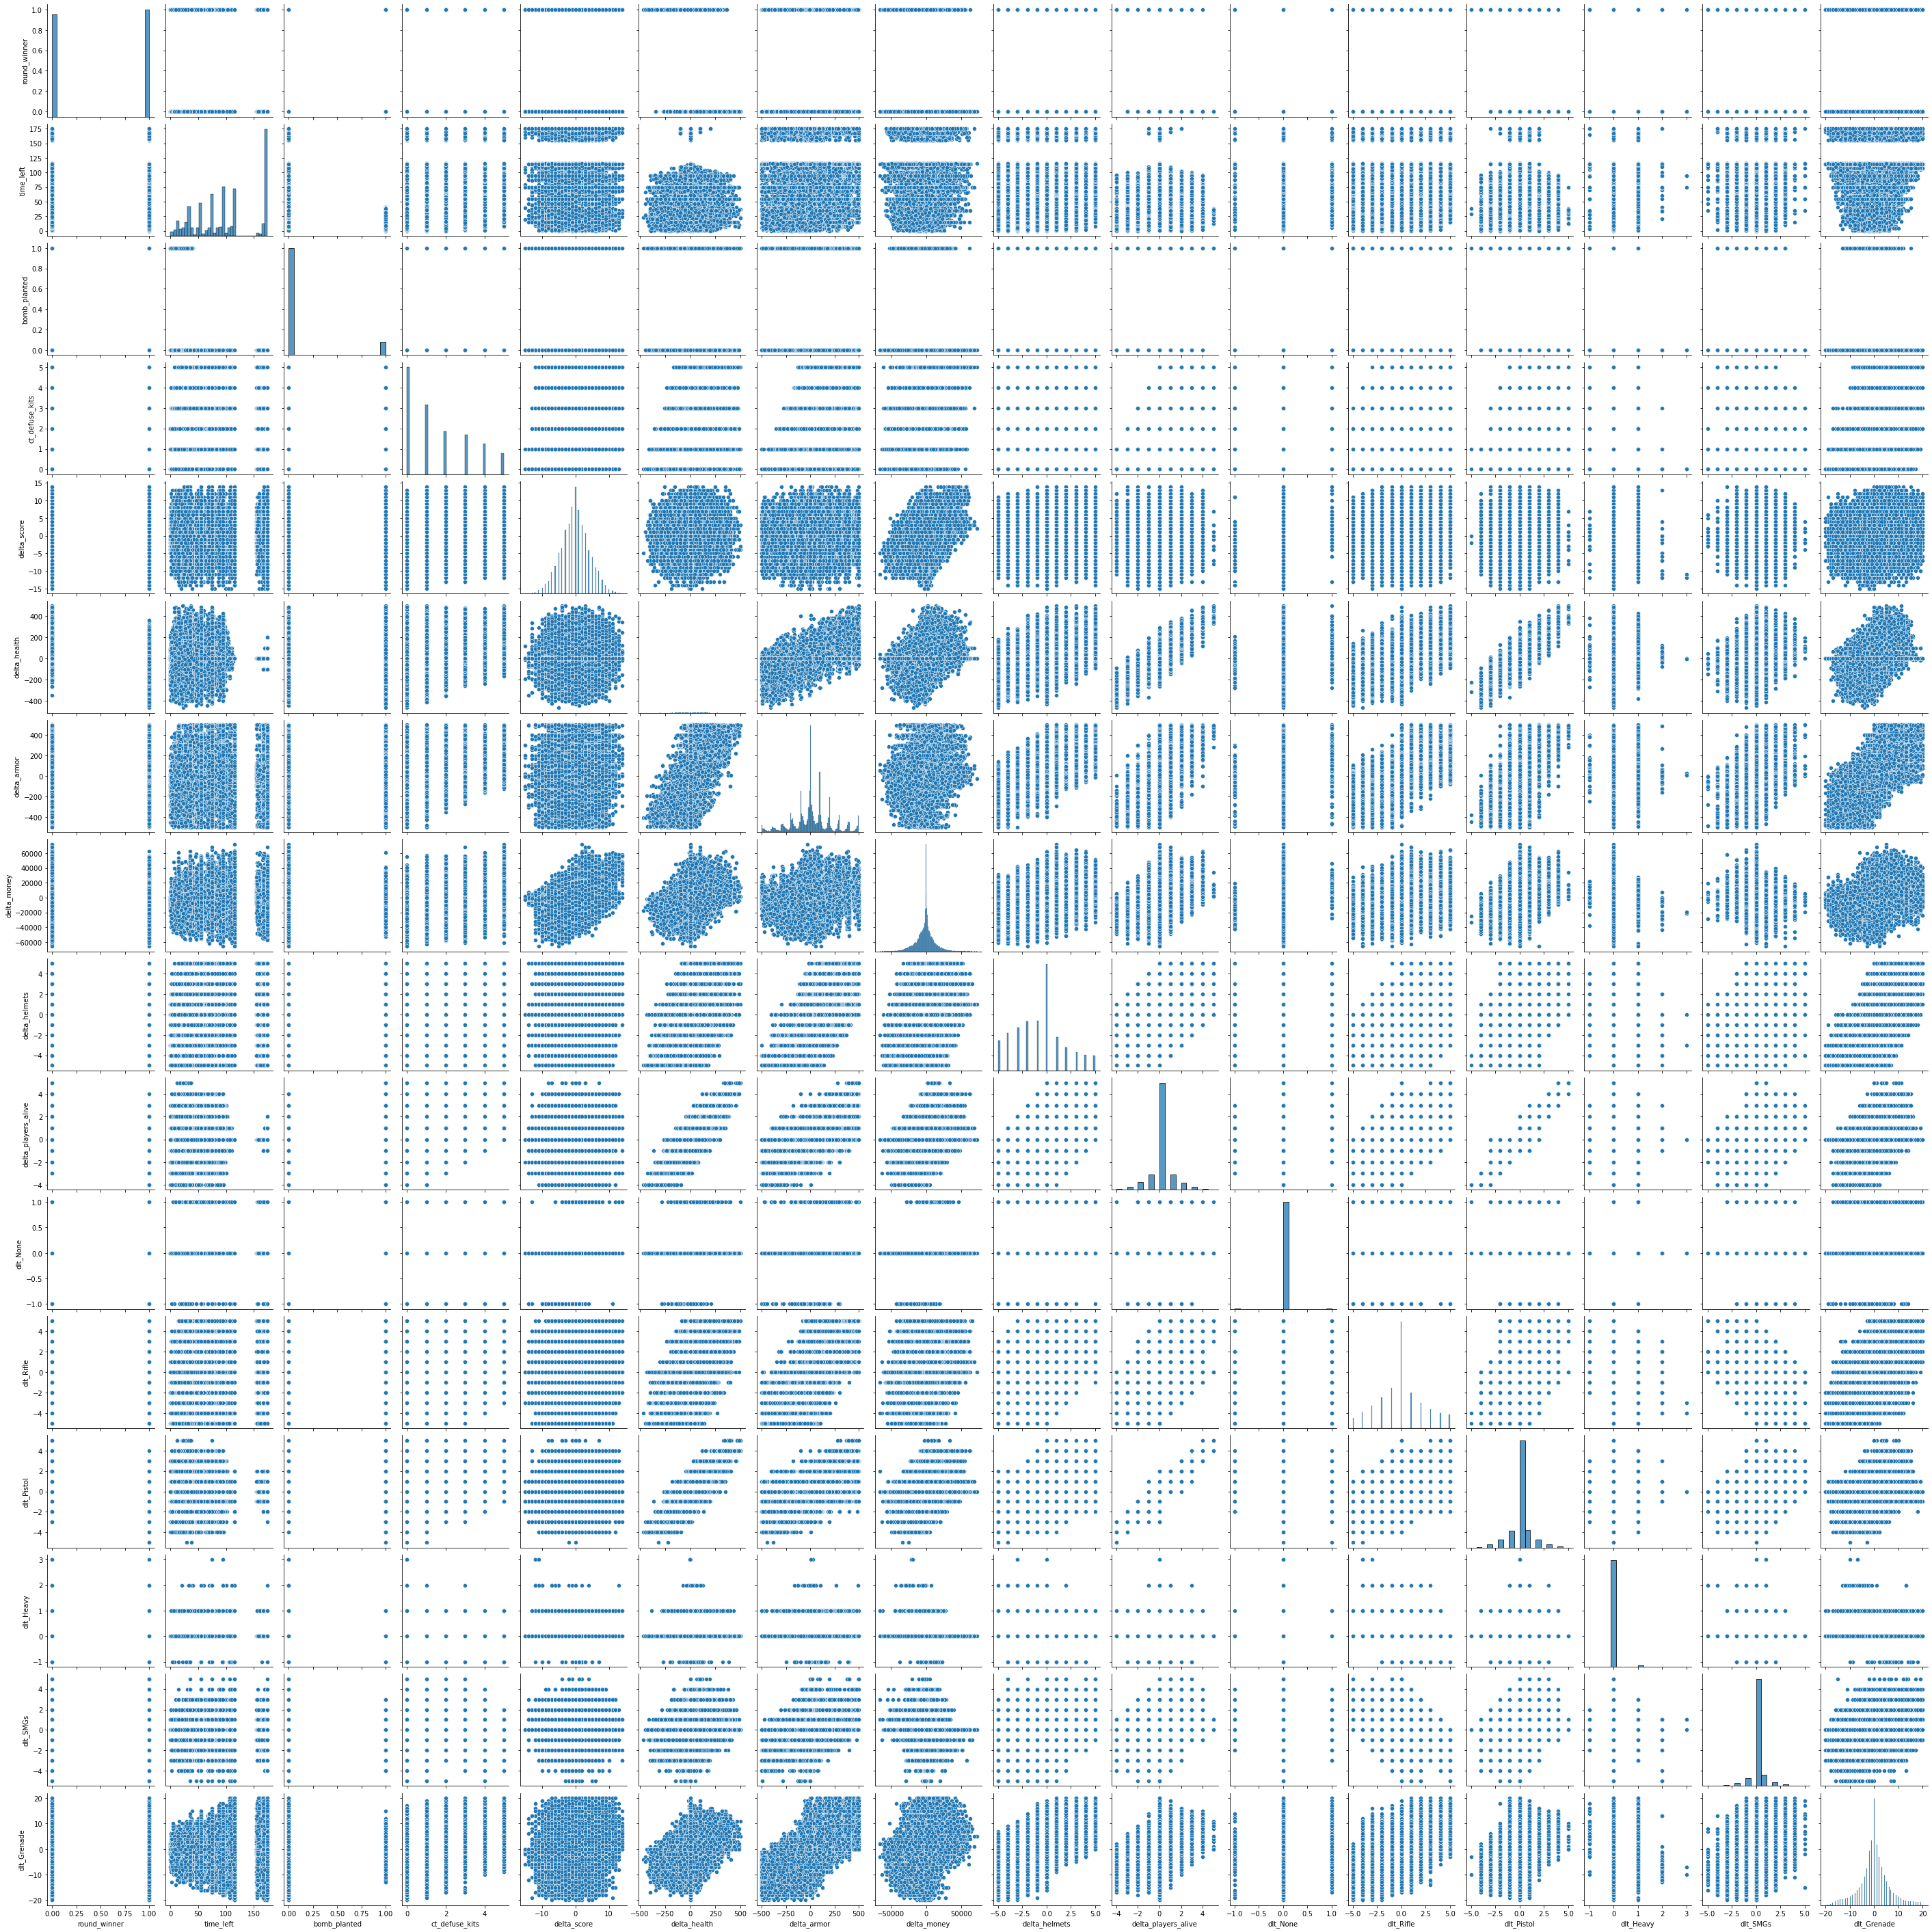

In [52]:
# Visualize weapcat_deltas_df

sns.pairplot(weapcat_deltas_df)

#### Normality testing - CURRENTLY NOT IN USE

In [53]:
# weapcat_sum_df['t_Grenade']

In [54]:
# df_input = pd.concat([weapcat_delta_df.iloc[:,1], weapcat_delta_df.iloc[:,3:]], axis = 1)
# df_input

In [55]:
# X = df_input.values # We do not take the class label
# X_std = StandardScaler().fit_transform(X) # normalizing the features
# test=pd.DataFrame(X_std) 
# test

In [56]:
# from matplotlib import pyplot
# from scipy.stats import shapiro
# from scipy.stats import normaltest
# #fig = plt.figure(figsize =(10, 7)) 

# # normality test
# stat, p = shapiro(weapcat_delta_df['delta_Pistol'])
# print('Statistics=%.3f, p=%.3f' % (stat, p))
# # interpret
# alpha = 0.05
# if p > alpha:
#     print('Sample looks Gaussian (fail to reject H0)')
# else:
#     print('Sample does not look Gaussian (reject H0)')

# # normality test
# stat, p = normaltest(weapcat_delta_df['delta_Pistol'])
# print('Statistics=%.3f, p=%.3f' % (stat, p))
# # interpret
# alpha = 0.05
# if p > alpha:
#     print('Sample looks Gaussian (fail to reject H0)')
# else:
#     print('Sample does not look Gaussian (reject H0)')


# #df.boxplot(['bomb_planted'], grid=False, fontsize=10)
# pyplot.hist(test.iloc[13])
# pyplot.show()

# pyplot.hist(weapcat_delta_df['delta_Grenade'])
# pyplot.show()

### PCA analysis

We will perform the following PCA analysis:
   1. Perform PCA on weapon variables (Non Standardised)
   2. Perform PCA on weapon variables (Standardised)
   3. Perform PCA on all variables (Standardised)
   4. Perform PCA on all ct and t variables separated (Standardised)
   5. Perform PCA on ct and t weapon variables separated (Non Standardised)
   6. Perform PCA on pairs of ct and t (Standardised)
   7. Perform PCA on delta of weapon variables (standardised and not standarized)
   8. Perform PCA on delta of weapon variables + variables without delta (standardised)
   9. Perform PCA on weapon variables grouped by category (standardised and non-stadardised)
   10. Perform PCA on weapon variables grouped by category + variables not grouped (standardised)
   11. Perform PCA on pairs of ct and t for weapon variables grouped by category  (non-standardised)
   12. Perform PCA on pairs of ct and t for weapon variables grouped by category for ct columns and t columns (stadardised)
   13. Perform PCA on delta of weapon variables grouped by category  +  variables not grouped (Standardised)
   14. Perform PCA from time left to players alive (19 variables) and for the grenades related variables


### 1. Perform PCA on weapon variables (Non Standardised)

In [57]:
df_input = df.iloc[:,15:] #take all weapon variables

In [58]:
df_input.head(2)

ct_helmets  t_helmets  ct_players_alive  t_players_alive  ct_weapon_ak47  \
0         4.0        5.0               4.0              5.0             2.0   
1         0.0        4.0               5.0              5.0             0.0   

   t_weapon_ak47  ct_weapon_aug  t_weapon_aug  ct_weapon_awp  t_weapon_awp  \
0            3.0            0.0           0.0            1.0           1.0   
1            3.0            0.0           0.0            0.0           1.0   

   ...  ct_grenade_hegrenade  t_grenade_hegrenade  ct_grenade_smokegrenade  \
0  ...                   0.0                  0.0                      2.0   
1  ...                   0.0                  1.0                      0.0   

   t_grenade_smokegrenade  ct_grenade_incendiarygrenade  \
0                     5.0                           1.0   
1                     2.0                           0.0   

   t_grenade_incendiarygrenade  ct_grenade_molotovgrenade  \
0                          0.0                        0.0   
1                          0.0                        0.0   

   t_grenade_molotovgrenade  ct_grenade_decoygrenade  t_grenade_decoygrenade  
0                       3.0                      0.0                     1.0  
1                       1.0                      0.0                     0.0  

[2 rows x 82 columns]

In [59]:
df_input.shape

(81999, 82)

In [60]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [61]:
X = df_input.values #transform data into an array

In [62]:
pca.fit(X) #fit the pca

PCA(n_components=0.9)

In [63]:
pca.n_components_ #show number of principal components created

15

In [64]:
df_pca = pca.transform(X) #create array with PC values

In [65]:
col = list(range(1,16)) #create columns for the df
#col

In [66]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df

In [67]:
principalDf.head(2)

1         2         3         4         5         6         7   \
0  3.735244 -2.461211  1.547472 -3.904288  0.236062 -0.737091  1.550257   
1 -0.759418 -2.549170 -1.100731  2.079234  2.411185 -0.109230  1.657158   

         8         9         10        11        12        13        14  \
0 -1.402365 -0.412306  0.267964 -0.944977  0.735276 -1.273671 -0.647599   
1  1.528620 -0.459245 -0.094225  0.275257 -0.008619 -0.519416  0.367790   

         15  
0  0.131866  
1 -0.381826

In [68]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
pca.explained_variance_ratio_

array([0.01001645, 0.01056271, 0.01179861, 0.01256883, 0.01340105,
       0.01454855, 0.01898807, 0.02491629, 0.0347416 , 0.03768577,
       0.04208432, 0.05809443, 0.12334052, 0.1644879 , 0.32630032])

In [69]:
# Check the correlation between each PC and the target variable, sorting the values as absolute

principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).abs().sort_values(ascending=False) 

2     0.447961
8     0.289319
12    0.065064
4     0.052176
9     0.052141
7     0.051505
15    0.031098
13    0.024525
14    0.016956
10    0.012379
11    0.011199
3     0.011180
5     0.010127
6     0.003260
dtype: float64

### 2. Perform PCA on weapon variables (Standardised)

In [70]:
df_input = df.iloc[:,15:] #take all weapon variables

In [71]:
df_input.head(2)

ct_helmets  t_helmets  ct_players_alive  t_players_alive  ct_weapon_ak47  \
0         4.0        5.0               4.0              5.0             2.0   
1         0.0        4.0               5.0              5.0             0.0   

   t_weapon_ak47  ct_weapon_aug  t_weapon_aug  ct_weapon_awp  t_weapon_awp  \
0            3.0            0.0           0.0            1.0           1.0   
1            3.0            0.0           0.0            0.0           1.0   

   ...  ct_grenade_hegrenade  t_grenade_hegrenade  ct_grenade_smokegrenade  \
0  ...                   0.0                  0.0                      2.0   
1  ...                   0.0                  1.0                      0.0   

   t_grenade_smokegrenade  ct_grenade_incendiarygrenade  \
0                     5.0                           1.0   
1                     2.0                           0.0   

   t_grenade_incendiarygrenade  ct_grenade_molotovgrenade  \
0                          0.0                        0.0   
1                          0.0                        0.0   

   t_grenade_molotovgrenade  ct_grenade_decoygrenade  t_grenade_decoygrenade  
0                       3.0                      0.0                     1.0  
1                       1.0                      0.0                     0.0  

[2 rows x 82 columns]

In [72]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [73]:
X_temp = df_input.values # We do not take the class label
X = StandardScaler().fit_transform(X_temp) # normalizing the features

In [74]:
pca.fit(X) #fit the pca

PCA(n_components=0.9)

In [75]:
pca.n_components_ #show number of principal components created

57

In [76]:
df_pca = pca.transform(X) #create array with PC values

In [77]:
col = list(range(1,58)) #create columns for the df
#col

In [78]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df

In [79]:
principalDf.head(2)

1         2         3         4         5         6         7   \
0  2.417955  1.105407  1.691514 -0.019985 -3.857425 -0.641458  4.642722   
1 -0.608211  1.161195 -1.146756 -0.733493  1.803071  0.830754  0.079510   

         8         9         10  ...        48        49        50        51  \
0  2.369452 -2.008004 -1.525928  ...  0.635405  0.680863 -1.744785 -0.168284   
1  1.273826  0.774725 -0.590696  ...  0.256240  0.200264 -0.514639 -0.060825   

         52        53        54        55        56        57  
0 -0.573342 -0.016219  0.708184 -1.057779 -0.367947  1.411423  
1  0.163467 -0.199083  0.100260  0.282987  0.525513  0.330919  

[2 rows x 57 columns]

In [80]:
#pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
pca.explained_variance_ratio_ 

array([0.07459432, 0.0443772 , 0.03514111, 0.02992646, 0.02631336,
       0.01920952, 0.0185023 , 0.01834504, 0.01592277, 0.01564375,
       0.01495075, 0.01441466, 0.01426252, 0.01409007, 0.01396108,
       0.01383882, 0.0138106 , 0.01376729, 0.0136659 , 0.01364326,
       0.01359404, 0.01356531, 0.01350015, 0.01345425, 0.01341111,
       0.01339067, 0.01335133, 0.01334168, 0.01332478, 0.01330637,
       0.01325239, 0.01323178, 0.01319496, 0.0131659 , 0.01309138,
       0.01297946, 0.01291941, 0.01287279, 0.01275401, 0.0127164 ,
       0.01263568, 0.0124795 , 0.01236539, 0.01229999, 0.01213685,
       0.0120127 , 0.01193864, 0.01180114, 0.01172498, 0.0114688 ,
       0.01140998, 0.01134805, 0.01123925, 0.01109305, 0.01086612,
       0.01067615, 0.01040003])

In [81]:
# Check the correlation between each PC and the target variable, sorting the values as absolute

principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).abs().sort_values(ascending=False).head(10)  #check the correlation between each PC and the target variable

2     0.423368
4     0.105344
3     0.055153
9     0.054323
45    0.052162
8     0.047411
5     0.047334
37    0.043535
35    0.039923
52    0.036500
dtype: float64

In [82]:
df_map_pca = pd.concat([df.iloc[:,0], principalDf.iloc[:,0:]], axis = 1)
df_map_pca.head()

round_winner         1         2         3         4         5         6  \
0             0  2.417955  1.105407  1.691514 -0.019985 -3.857425 -0.641458   
1             1 -0.608211  1.161195 -1.146756 -0.733493  1.803071  0.830754   
2             1  3.389749 -2.905312 -0.396312  0.845186 -2.264634  0.703248   
3             0  3.033188 -0.225456 -1.718900 -0.508447  0.568306 -0.626989   
4             1 -2.405345 -0.230083 -2.390830  1.361087 -0.654890 -0.037418   

          7         8         9  ...        48        49        50        51  \
0  4.642722  2.369452 -2.008004  ...  0.635405  0.680863 -1.744785 -0.168284   
1  0.079510  1.273826  0.774725  ...  0.256240  0.200264 -0.514639 -0.060825   
2  2.381534  2.003785  0.223092  ... -0.019996 -1.182541 -0.082698  0.308278   
3 -0.029483 -1.003421 -0.112867  ... -0.172250  0.080574  0.045716 -0.069341   
4  0.074520 -0.325374 -0.957202  ... -0.417682 -1.042327 -0.240369  0.040826   

         52        53        54        55        56        57  
0 -0.573342 -0.016219  0.708184 -1.057779 -0.367947  1.411423  
1  0.163467 -0.199083  0.100260  0.282987  0.525513  0.330919  
2  0.241456  0.544687  0.263555 -0.797054 -1.524536 -0.428460  
3 -0.207233  0.275627  0.360064  0.014092  0.198538 -0.611324  
4  0.305657 -0.522488 -0.440051 -0.506161 -0.398614  0.713016  

[5 rows x 58 columns]

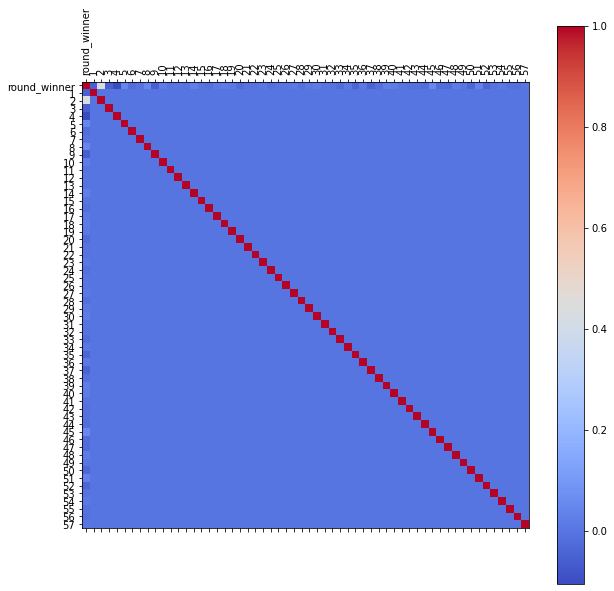

In [83]:
# Plot the pca result

f = plt.figure(figsize=(10, 10))
plt.matshow(df_map_pca.corr(), fignum=f.number, cmap=plt.cm.coolwarm)
plt.xticks(range(df_map_pca.shape[1]), df_map_pca.columns, fontsize=10, rotation=90)
plt.yticks(range(df_map_pca.shape[1]), df_map_pca.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

In [84]:
# Analyzing 'mi' with the pca results and the target variable

mi_pca = mutual_info_classif(df_map_pca.drop(["round_winner"], axis=1), df_map_pca.round_winner)
mi_pca_df = pd.DataFrame(mi_pca,index=df_map_pca.iloc[:,1:].columns, columns =['mi_score'])
mi_pca_df[mi_pca_df['mi_score']>0.05].sort_values(by='mi_score', ascending=False)

mi_score
2   0.147871
4   0.059444
27  0.053634
37  0.052349
20  0.050233

### 3. Perform PCA on all variables (Standardised)

In [85]:
df_input = pd.concat([df.iloc[:,1], df.iloc[:,3:]], axis = 1)
df_input.head(2)

time_left  bomb_planted  ct_defuse_kits  ct_grenade_flashbang  \
0      94.96           0.0             4.0                   3.0   
1     175.00           0.0             0.0                   0.0   

   t_grenade_flashbang  ct_score  t_score  ct_health  t_health  ct_armor  ...  \
0                  5.0      11.0      2.0      392.0     500.0     379.0  ...   
1                  3.0      13.0      9.0      500.0     500.0       0.0  ...   

   ct_grenade_hegrenade  t_grenade_hegrenade  ct_grenade_smokegrenade  \
0                   0.0                  0.0                      2.0   
1                   0.0                  1.0                      0.0   

   t_grenade_smokegrenade  ct_grenade_incendiarygrenade  \
0                     5.0                           1.0   
1                     2.0                           0.0   

   t_grenade_incendiarygrenade  ct_grenade_molotovgrenade  \
0                          0.0                        0.0   
1                          0.0                        0.0   

   t_grenade_molotovgrenade  ct_grenade_decoygrenade  t_grenade_decoygrenade  
0                       3.0                      0.0                     1.0  
1                       1.0                      0.0                     0.0  

[2 rows x 95 columns]

In [86]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [87]:
X_temp = df_input.values # We do not take the class label
X = StandardScaler().fit_transform(X_temp) # normalizing the features

In [88]:
pca.fit(X) #fit the pca

PCA(n_components=0.9)

In [89]:
pca.n_components_ #show number of principal components created

61

In [90]:
df_pca = pca.transform(X) #create array with PC values

In [91]:
col = list(range(1,62)) #create columns for the df
#col

In [92]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df

In [93]:
principalDf.head(2)

1         2         3         4         5         6         7   \
0  3.176769  1.447567  0.951130  0.286117  4.414255 -1.754254 -0.431298   
1 -0.448566 -0.020902 -3.355539 -2.359450 -0.328105  3.046626  0.002539   

         8         9         10  ...        52        53        54        55  \
0  1.864554  4.911601  0.338591  ... -1.000538 -0.550254  1.576516 -0.892972   
1 -0.017522  0.896791 -0.367700  ...  0.022570 -0.474219  0.290432  0.314978   

         56        57        58        59        60        61  
0 -0.836447 -0.730398 -1.735002  0.048145  1.100543  0.048388  
1 -0.092434 -0.195059 -0.100659  0.577435  0.455448 -1.741642  

[2 rows x 61 columns]

In [94]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

variance expl: 0.00878 - 0.09856


In [95]:
principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).sort_values() #check the correlation between each PC and the target variable

3    -0.253066
4    -0.090376
20   -0.049363
50   -0.043333
60   -0.034225
46   -0.031641
17   -0.031224
61   -0.031171
47   -0.030815
7    -0.030373
14   -0.028330
23   -0.025428
54   -0.023090
59   -0.020821
38   -0.018584
53   -0.018192
34   -0.016741
24   -0.016271
21   -0.013737
39   -0.012692
48   -0.011566
27   -0.011485
51   -0.010535
42   -0.010277
15   -0.006649
30   -0.002298
29   -0.000962
12    0.000229
35    0.000659
26    0.002904
11    0.016937
6     0.019513
55    0.020961
32    0.021196
9     0.022592
22    0.023675
31    0.024450
33    0.025514
58    0.027020
28    0.027070
5     0.029033
41    0.029080
40    0.030337
18    0.032259
56    0.036024
36    0.041261
49    0.043990
19    0.044827
45    0.044853
43    0.045119
25    0.047502
37    0.053620
44    0.057859
57    0.065500
52    0.070405
8     0.070706
13    0.089062
16    0.100006
10    0.117659
2     0.385942
dtype: float64

In [96]:
a =  principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

correlation: -0.25307 - 0.38594


### 4. Perform PCA on all ct and t variables separated (Standardised)

In [97]:
df_input = df.iloc[:,5:]
df_input.head(2)

ct_grenade_flashbang  t_grenade_flashbang  ct_score  t_score  ct_health  \
0                   3.0                  5.0      11.0      2.0      392.0   
1                   0.0                  3.0      13.0      9.0      500.0   

   t_health  ct_armor  t_armor  ct_money  t_money  ...  ct_grenade_hegrenade  \
0     500.0     379.0    500.0   23300.0   2500.0  ...                   0.0   
1     500.0       0.0    300.0   28150.0  44350.0  ...                   0.0   

   t_grenade_hegrenade  ct_grenade_smokegrenade  t_grenade_smokegrenade  \
0                  0.0                      2.0                     5.0   
1                  1.0                      0.0                     2.0   

   ct_grenade_incendiarygrenade  t_grenade_incendiarygrenade  \
0                           1.0                          0.0   
1                           0.0                          0.0   

   ct_grenade_molotovgrenade  t_grenade_molotovgrenade  \
0                        0.0                       3.0   
1                        0.0                       1.0   

   ct_grenade_decoygrenade  t_grenade_decoygrenade  
0                      0.0                     1.0  
1                      0.0                     0.0  

[2 rows x 92 columns]

In [98]:
df_input_ct = df_input.iloc[:, list(range(0, len(df_input.columns), 2))]
df_input_ct.head(2)

ct_grenade_flashbang  ct_score  ct_health  ct_armor  ct_money  ct_helmets  \
0                   3.0      11.0      392.0     379.0   23300.0         4.0   
1                   0.0      13.0      500.0       0.0   28150.0         0.0   

   ct_players_alive  ct_weapon_ak47  ct_weapon_aug  ct_weapon_awp  ...  \
0               4.0             2.0            0.0            1.0  ...   
1               5.0             0.0            0.0            0.0  ...   

   ct_weapon_fiveseven  ct_weapon_usps  ct_weapon_p250  ct_weapon_p2000  \
0                  0.0             0.0             1.0              0.0   
1                  0.0             5.0             0.0              0.0   

   ct_weapon_tec9  ct_grenade_hegrenade  ct_grenade_smokegrenade  \
0             1.0                   0.0                      2.0   
1             0.0                   0.0                      0.0   

   ct_grenade_incendiarygrenade  ct_grenade_molotovgrenade  \
0                           1.0                        0.0   
1                           0.0                        0.0   

   ct_grenade_decoygrenade  
0                      0.0  
1                      0.0  

[2 rows x 46 columns]

In [99]:
df_input_t = df_input.iloc[:, list(range(1, len(df_input.columns), 2))]
df_input_t.head(2)

t_grenade_flashbang  t_score  t_health  t_armor  t_money  t_helmets  \
0                  5.0      2.0     500.0    500.0   2500.0        5.0   
1                  3.0      9.0     500.0    300.0  44350.0        4.0   

   t_players_alive  t_weapon_ak47  t_weapon_aug  t_weapon_awp  ...  \
0              5.0            3.0           0.0           1.0  ...   
1              5.0            3.0           0.0           1.0  ...   

   t_weapon_fiveseven  t_weapon_usps  t_weapon_p250  t_weapon_p2000  \
0                 0.0            0.0            0.0             0.0   
1                 0.0            0.0            1.0             0.0   

   t_weapon_tec9  t_grenade_hegrenade  t_grenade_smokegrenade  \
0            0.0                  0.0                     5.0   
1            0.0                  1.0                     2.0   

   t_grenade_incendiarygrenade  t_grenade_molotovgrenade  \
0                          0.0                       3.0   
1                          0.0                       1.0   

   t_grenade_decoygrenade  
0                     1.0  
1                     0.0  

[2 rows x 46 columns]

**'CT' Variables**

In [100]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [101]:
X_temp = df_input_ct.values # We do not take the class label
X = StandardScaler().fit_transform(X_temp) # normalizing the features

In [102]:
pca.fit(X) #fit the pca

PCA(n_components=0.9)

In [103]:
pca.n_components_ #show number of principal components created

29

In [104]:
df_pca = pca.transform(X) #create array with PC values

In [105]:
col = list(range(1,30)) #create columns for the df
#col

In [106]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df

In [107]:
principalDf.head(2)

1         2         3         4         5         6         7   \
0  1.422292  3.824955  1.600344  0.447250  2.583295  5.873144 -1.074742   
1 -2.116804 -1.476283  2.442266 -0.148236  0.758165 -0.254029 -0.808184   

         8         9         10  ...        20        21        22        23  \
0  5.519261 -0.185957 -2.479562  ...  1.322227 -1.007464 -0.555146  2.264752   
1 -0.204463 -0.145987 -0.321619  ...  0.488882  0.475494 -0.176752  0.268433   

         24        25        26        27        28        29  
0  3.789253 -0.329753  0.078282  0.025507  0.514367  0.524410  
1 -0.193526  0.120266 -0.311750  1.070721 -0.129580 -0.301208  

[2 rows x 29 columns]

In [108]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

variance expl: 0.01948 - 0.15089


In [109]:
principalDf.iloc[:,0].corr(df.iloc[:, 0]) #check the correlation between each PC and the target variable

-0.3183851639756392

In [110]:
a =  principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

correlation: -0.07089 - 0.03897


**'T' Variables**

In [111]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [112]:
X_temp = df_input_t.values # We do not take the class label
X = StandardScaler().fit_transform(X_temp) # normalizing the features

In [113]:
pca.fit(X) #fit the pca

PCA(n_components=0.9)

In [114]:
pca.n_components_ #show number of principal components created

33

In [115]:
df_pca = pca.transform(X) #create array with PC values

In [116]:
col = list(range(1,34)) #create columns for the df
#col

In [117]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df

In [118]:
principalDf.head(2)

1         2         3         4         5         6         7   \
0  3.285939 -0.526446  1.956152 -1.521857 -1.422592 -0.337314  1.557616   
1  1.483306  0.223752 -1.843309  2.063420  1.195251  0.392789  0.709285   

         8         9         10  ...        24        25        26        27  \
0 -0.154998  0.055489  1.481764  ...  1.039558 -1.367430  0.506031  1.511607   
1  0.007919 -0.887479  0.253989  ...  0.309873 -0.771567  0.004245  0.229273   

         28        29        30        31        32        33  
0 -0.914415 -1.467802  0.337260  0.059740 -0.956576  0.337695  
1 -0.291462  0.024355 -0.287714  0.413118  0.118057 -1.259628  

[2 rows x 33 columns]

In [119]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

variance expl: 0.01752 - 0.12937


In [120]:
a =  principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

correlation: -0.0668 - 0.0836


### 5. Perform PCA on ct and t weapon variables separated (Non Standardised)

In [121]:
df_input = df.iloc[:,5:]
df_input.head(2)

ct_grenade_flashbang  t_grenade_flashbang  ct_score  t_score  ct_health  \
0                   3.0                  5.0      11.0      2.0      392.0   
1                   0.0                  3.0      13.0      9.0      500.0   

   t_health  ct_armor  t_armor  ct_money  t_money  ...  ct_grenade_hegrenade  \
0     500.0     379.0    500.0   23300.0   2500.0  ...                   0.0   
1     500.0       0.0    300.0   28150.0  44350.0  ...                   0.0   

   t_grenade_hegrenade  ct_grenade_smokegrenade  t_grenade_smokegrenade  \
0                  0.0                      2.0                     5.0   
1                  1.0                      0.0                     2.0   

   ct_grenade_incendiarygrenade  t_grenade_incendiarygrenade  \
0                           1.0                          0.0   
1                           0.0                          0.0   

   ct_grenade_molotovgrenade  t_grenade_molotovgrenade  \
0                        0.0                       3.0   
1                        0.0                       1.0   

   ct_grenade_decoygrenade  t_grenade_decoygrenade  
0                      0.0                     1.0  
1                      0.0                     0.0  

[2 rows x 92 columns]

In [122]:
df_input_w = df_input.iloc[:,10:]
df_input_w.head(2)

ct_helmets  t_helmets  ct_players_alive  t_players_alive  ct_weapon_ak47  \
0         4.0        5.0               4.0              5.0             2.0   
1         0.0        4.0               5.0              5.0             0.0   

   t_weapon_ak47  ct_weapon_aug  t_weapon_aug  ct_weapon_awp  t_weapon_awp  \
0            3.0            0.0           0.0            1.0           1.0   
1            3.0            0.0           0.0            0.0           1.0   

   ...  ct_grenade_hegrenade  t_grenade_hegrenade  ct_grenade_smokegrenade  \
0  ...                   0.0                  0.0                      2.0   
1  ...                   0.0                  1.0                      0.0   

   t_grenade_smokegrenade  ct_grenade_incendiarygrenade  \
0                     5.0                           1.0   
1                     2.0                           0.0   

   t_grenade_incendiarygrenade  ct_grenade_molotovgrenade  \
0                          0.0                        0.0   
1                          0.0                        0.0   

   t_grenade_molotovgrenade  ct_grenade_decoygrenade  t_grenade_decoygrenade  
0                       3.0                      0.0                     1.0  
1                       1.0                      0.0                     0.0  

[2 rows x 82 columns]

In [123]:
df_input_ct = df_input_w.iloc[:, list(range(0, len(df_input_w.columns), 2))]
df_input_ct.head(2)

ct_helmets  ct_players_alive  ct_weapon_ak47  ct_weapon_aug  ct_weapon_awp  \
0         4.0               4.0             2.0            0.0            1.0   
1         0.0               5.0             0.0            0.0            0.0   

   ct_weapon_bizon  ct_weapon_cz75auto  ct_weapon_elite  ct_weapon_famas  \
0              0.0                 0.0              0.0              0.0   
1              0.0                 0.0              0.0              0.0   

   ct_weapon_g3sg1  ...  ct_weapon_fiveseven  ct_weapon_usps  ct_weapon_p250  \
0              0.0  ...                  0.0             0.0             1.0   
1              0.0  ...                  0.0             5.0             0.0   

   ct_weapon_p2000  ct_weapon_tec9  ct_grenade_hegrenade  \
0              0.0             1.0                   0.0   
1              0.0             0.0                   0.0   

   ct_grenade_smokegrenade  ct_grenade_incendiarygrenade  \
0                      2.0                           1.0   
1                      0.0                           0.0   

   ct_grenade_molotovgrenade  ct_grenade_decoygrenade  
0                        0.0                      0.0  
1                        0.0                      0.0  

[2 rows x 41 columns]

In [124]:
df_input_t = df_input_w.iloc[:, list(range(1, len(df_input_w.columns), 2))]
df_input_t.head(2)

t_helmets  t_players_alive  t_weapon_ak47  t_weapon_aug  t_weapon_awp  \
0        5.0              5.0            3.0           0.0           1.0   
1        4.0              5.0            3.0           0.0           1.0   

   t_weapon_bizon  t_weapon_cz75auto  t_weapon_elite  t_weapon_famas  \
0             0.0                0.0             0.0             0.0   
1             0.0                0.0             0.0             0.0   

   t_weapon_g3sg1  ...  t_weapon_fiveseven  t_weapon_usps  t_weapon_p250  \
0             0.0  ...                 0.0            0.0            0.0   
1             0.0  ...                 0.0            0.0            1.0   

   t_weapon_p2000  t_weapon_tec9  t_grenade_hegrenade  t_grenade_smokegrenade  \
0             0.0            0.0                  0.0                     5.0   
1             0.0            0.0                  1.0                     2.0   

   t_grenade_incendiarygrenade  t_grenade_molotovgrenade  \
0                          0.0                       3.0   
1                          0.0                       1.0   

   t_grenade_decoygrenade  
0                     1.0  
1                     0.0  

[2 rows x 41 columns]

**'CT' Variables**

In [125]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [126]:
X = df_input_ct.values # We do not take the class label

In [127]:
pca.fit(X) #fit the pca

PCA(n_components=0.9)

In [128]:
pca.n_components_ #show number of principal components created

9

In [129]:
df_pca = pca.transform(X) #create array with PC values

In [130]:
col = list(range(1,10)) #create columns for the df
#col

In [131]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df

In [132]:
principalDf.head(2)

1         2         3         4         5         6         7  \
0  0.381077  3.792318 -1.609009  1.030938  0.170175 -0.952896 -0.883520   
1 -2.682701 -2.558173 -0.029855  0.579384 -0.209644  0.159032 -0.056227   

          8         9  
0 -0.140451 -0.959395  
1  0.142954  0.014290

In [133]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

variance expl: 0.01795 - 0.45966


In [134]:
a =  principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

correlation: 0.01069 - 0.20438


**'T' Variables**

In [135]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [136]:
X = df_input_t.values # We do not take the class label

In [137]:
pca.fit(X) #fit the pca

PCA(n_components=0.9)

In [138]:
pca.n_components_ #show number of principal components created

7

In [139]:
df_pca = pca.transform(X) #create array with PC values

In [140]:
col = list(range(1,8)) #create columns for the df
#col

In [141]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df

In [142]:
principalDf.head(2)

1         2         3         4         5         6         7
0  4.518114 -1.070948 -1.246071 -0.892142 -0.355678  1.187377 -0.777300
1  1.128244  1.436321 -1.711602 -0.192225  1.980487 -0.044557 -0.079399

In [143]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

variance expl: 0.02219 - 0.50326


In [144]:
a =  principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

correlation: -0.07218 - 0.21367


### 6. Perform PCA on pairs of ct and t (Standardised)

#### A. Players alive

In [145]:
df_input = df[["ct_players_alive", "t_players_alive"]]
df_input.head(2)

ct_players_alive  t_players_alive
0               4.0              5.0
1               5.0              5.0

In [146]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [147]:
X_temp = df_input.values # We do not take the class label
X = StandardScaler().fit_transform(X_temp) # normalizing the features

In [148]:
pca.fit(X) #fit the pca

PCA(n_components=0.9)

In [149]:
pca.n_components_ #show number of principal components created

2

In [150]:
df_pca = pca.transform(X) #create array with PC values

In [151]:
col = list(range(1,3)) #create columns for the df
#col

In [152]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df

In [153]:
principalDf.head(2)

1         2
0 -0.261556 -0.583483
1 -0.848459  0.003420

In [154]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))
a =  principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

variance expl: 0.18639 - 0.81361
correlation: -0.41483 - -0.41483


#### B. Health

In [155]:
df_input = df[["ct_health", "t_health"]]
df_input.head(2)

ct_health  t_health
0      392.0     500.0
1      500.0     500.0

In [156]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [157]:
X_temp = df_input.values # We do not take the class label
X = StandardScaler().fit_transform(X_temp) # normalizing the features

In [158]:
pca.fit(X) #fit the pca

PCA(n_components=0.9)

In [159]:
pca.n_components_ #show number of principal components created

2

In [160]:
df_pca = pca.transform(X) #create array with PC values

In [161]:
col = list(range(1,3)) #create columns for the df
#col

In [162]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df

In [163]:
principalDf.head(2)

1         2
0 -0.384237  0.599047
1 -0.961495  0.021789

In [164]:
pca.explained_variance_ratio_ #show the percentage of the variance explained by each PC

array([0.87856848, 0.12143152])

In [165]:
principalDf.iloc[:,0].corr(df.iloc[:, 0]) #check the correlation between each PC and the target variable

0.054060347479708094

In [166]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

a =  principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

variance expl: 0.12143 - 0.87857
correlation: 0.40355 - 0.40355


#### C. Money

In [167]:
df_input = df[["ct_money", "t_money"]]
df_input.head(2)

ct_money  t_money
0   23300.0   2500.0
1   28150.0  44350.0

In [168]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [169]:
X_temp = df_input.values # We do not take the class label
X = StandardScaler().fit_transform(X_temp) # normalizing the features

In [170]:
pca.fit(X) #fit the pca

PCA(n_components=0.9)

In [171]:
pca.n_components_ #show number of principal components created

2

In [172]:
df_pca = pca.transform(X) #create array with PC values

In [173]:
col = list(range(1,3)) #create columns for the df
#col

In [174]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df

In [175]:
principalDf.head(2)

1         2
0  0.342718  1.357770
1  3.087315 -0.776048

In [176]:
pca.explained_variance_ratio_ #show the percentage of the variance explained by each PC

array([0.68628127, 0.31371873])

In [177]:
principalDf.iloc[:,1].corr(df.iloc[:, 0]) #check the correlation between each PC and the target variable

-0.2045365742669747

In [178]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

a =  principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

variance expl: 0.31372 - 0.68628
correlation: -0.20454 - -0.20454


#### D. Armor

In [179]:
df_input = df[["ct_armor", "t_armor"]]
df_input.head(2)

ct_armor  t_armor
0     379.0    500.0
1       0.0    300.0

In [180]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [181]:
X_temp = df_input.values # We do not take the class label
X = StandardScaler().fit_transform(X_temp) # normalizing the features

In [182]:
pca.fit(X) #fit the pca

PCA(n_components=0.9)

In [183]:
pca.n_components_ #show number of principal components created

2

In [184]:
df_pca = pca.transform(X) #create array with PC values

In [185]:
col = list(range(1,3)) #create columns for the df
col

[1, 2]

In [186]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df

In [187]:
principalDf.head(2)

1         2
0 -1.084448  0.547563
1  1.293162  1.303374

In [188]:
pca.explained_variance_ratio_ #show the percentage of the variance explained by each PC

array([0.64736498, 0.35263502])

In [189]:
principalDf.iloc[:,0].corr(df.iloc[:, 0]) #check the correlation between each PC and the target variable

0.029713554562529883

In [190]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

a =  principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

variance expl: 0.35264 - 0.64736
correlation: 0.52837 - 0.52837


<img style="float: left;" src="i-wrote-dis.jpg">

### 7. Perform PCA on delta of weapon variables (standardised and not standarized)

In [191]:
df_input = delta_df.iloc[:,np.r_[5, 10:len(delta_df.columns)]]
df_input.head(2)

delta_grenade_flashbang  delta_helmets  delta_players_alive  \
0                     -2.0           -1.0                 -1.0   
1                     -3.0           -4.0                  0.0   

   delta_weapon_ak47  delta_weapon_aug  delta_weapon_awp  delta_weapon_bizon  \
0               -1.0               0.0               0.0                 0.0   
1               -3.0               0.0              -1.0                 0.0   

   delta_weapon_cz75auto  delta_weapon_elite  delta_weapon_famas  ...  \
0                    0.0                 0.0                 0.0  ...   
1                    0.0                 0.0                 0.0  ...   

   delta_weapon_usps  delta_weapon_p250  delta_weapon_p2000  \
0                0.0                1.0                 0.0   
1                5.0               -1.0                 0.0   

   delta_weapon_tec9  delta_grenade_hegrenade  delta_grenade_smokegrenade  \
0                1.0                      0.0                        -3.0   
1                0.0                     -1.0                        -2.0   

   delta_grenade_incendiarygrenade  delta_grenade_molotovgrenade  \
0                              1.0                          -3.0   
1                              0.0                          -1.0   

   delta_grenade_decoygrenade  delta_ta_grenade_flashbang  
0                        -1.0                       -11.0  
1                         0.0                        -7.0  

[2 rows x 43 columns]

In [192]:
X = df_input.values # We do not take the class label
X_std = StandardScaler().fit_transform(X) # normalizing the features

**Non Standardized**

In [193]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [194]:
pca.fit(X) #fit the pca

PCA(n_components=0.9)

In [195]:
pca.n_components_ #show number of principal components created

10

In [196]:
df_pca = pca.transform(X) #create array with PC values

In [197]:
col = list(range(1,df_pca.shape[1]+1)) #create columns for the df
#col

In [198]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df
principalDf.head(2)

1         2         3         4         5         6         7   \
0 -11.478835  2.956317 -0.571928  0.996974  3.265698  1.565798 -0.072653   
1  -8.355071 -0.390287 -0.821661 -1.122878 -3.712204 -1.542951 -1.959203   

         8         9         10  
0 -0.476712 -0.923494  0.749039  
1 -0.889146 -0.220536 -0.375335

In [199]:
pca.explained_variance_ratio_ #show the percentage of the variance explained by each PC

array([0.37457752, 0.22572308, 0.09118109, 0.05914847, 0.04573951,
       0.03266913, 0.02915444, 0.02212189, 0.01794549, 0.01594124])

In [200]:
principalDf.iloc[:,2].corr(df.iloc[:, 0]) #check the correlation between each PC and the target variable

-0.07695253153659837

In [201]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

a =  principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

variance expl: 0.01594 - 0.37458
correlation: -0.36282 - 0.08227


**Standarized**

In [202]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [203]:
pca.fit(X_std) #fit the pca

PCA(n_components=0.9)

In [204]:
pca.n_components_ #show number of principal components created

32

In [205]:
df_pca = pca.transform(X_std) #create array with PC values

In [206]:
col = list(range(1,df_pca.shape[1]+1)) #create columns for the df
#col

In [207]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df
principalDf.head(2)

1         2         3         4         5         6         7   \
0 -2.802924 -0.048413  3.524468 -1.938478 -0.542191 -0.626239  0.801179   
1 -2.354678 -0.586476 -2.480439 -0.261964  0.689110 -0.376024  0.465037   

         8         9         10  ...        23        24        25        26  \
0  0.195618 -1.289049  0.965189  ...  2.396575  3.050125 -0.937455  3.119526   
1  1.365764  0.042769  0.070690  ...  0.263650  0.650385 -0.645265 -0.253217   

         27       28        29        30        31        32  
0  0.312469 -1.19781 -0.716673 -0.203184  1.393817  1.120751  
1 -0.535322  0.05157  1.303724  0.066951  0.912139  0.686444  

[2 rows x 32 columns]

In [208]:
pca.explained_variance_ratio_ #show the percentage of the variance explained by each PC

array([0.10667937, 0.05825806, 0.0444728 , 0.03470232, 0.03225806,
       0.0278571 , 0.0272532 , 0.02601303, 0.02588544, 0.02536599,
       0.02474563, 0.0243088 , 0.02419527, 0.02400798, 0.023915  ,
       0.02386241, 0.02380774, 0.02377173, 0.02370842, 0.02360356,
       0.02340406, 0.02306764, 0.02273402, 0.0223709 , 0.02218381,
       0.0219444 , 0.02133985, 0.02110382, 0.02092821, 0.02066962,
       0.01989508, 0.01890556])

In [209]:
principalDf.iloc[:,2].corr(df.iloc[:, 0]) #check the correlation between each PC and the target variable

-0.07576354645481856

In [210]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

a =  principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

variance expl: 0.01891 - 0.10668
correlation: -0.19048 - 0.13883


### 8. Perform PCA on delta of weapon variables + variables without delta (standardised)

In [211]:
df_input = pd.concat([delta_df.iloc[:,1], df.iloc[:,3:]], axis = 1)
df_input.head(2)

time_left  bomb_planted  ct_defuse_kits  ct_grenade_flashbang  \
0      94.96           0.0             4.0                   3.0   
1     175.00           0.0             0.0                   0.0   

   t_grenade_flashbang  ct_score  t_score  ct_health  t_health  ct_armor  ...  \
0                  5.0      11.0      2.0      392.0     500.0     379.0  ...   
1                  3.0      13.0      9.0      500.0     500.0       0.0  ...   

   ct_grenade_hegrenade  t_grenade_hegrenade  ct_grenade_smokegrenade  \
0                   0.0                  0.0                      2.0   
1                   0.0                  1.0                      0.0   

   t_grenade_smokegrenade  ct_grenade_incendiarygrenade  \
0                     5.0                           1.0   
1                     2.0                           0.0   

   t_grenade_incendiarygrenade  ct_grenade_molotovgrenade  \
0                          0.0                        0.0   
1                          0.0                        0.0   

   t_grenade_molotovgrenade  ct_grenade_decoygrenade  t_grenade_decoygrenade  
0                       3.0                      0.0                     1.0  
1                       1.0                      0.0                     0.0  

[2 rows x 95 columns]

In [212]:
X_std = df_input.values # We do not take the class label

In [213]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [214]:
pca.fit(X_std) #fit the pca

PCA(n_components=0.9)

In [215]:
pca.n_components_ #show number of principal components created

2

In [216]:
df_pca = pca.transform(X_std) #create array with PC values

In [217]:
col = list(range(1,df_pca.shape[1]+1)) #create columns for the df
#col

In [218]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df
principalDf.head(2)

1             2
0   1768.187075  15969.150104
1  37291.269221  -6682.975322

In [219]:
pca.explained_variance_ratio_ #show the percentage of the variance explained by each PC

array([0.68945493, 0.31020234])

In [220]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

a =  principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

variance expl: 0.3102 - 0.68945
correlation: -0.20565 - -0.20565


### 9. Perform PCA on weapon variables grouped by category (standardised and non-stadardised)

In [221]:
df_input = weapcat_sum_df.iloc[:,17:]
df_input.head(2)

ct_None  t_None  ct_Rifle  t_Rifle  ct_Pistol  t_Pistol  ct_Heavy  t_Heavy  \
0      0.0     0.0       4.0      4.0        4.0       5.0       0.0      0.0   
1      0.0     0.0       0.0      4.0        5.0       5.0       0.0      0.0   

   ct_SMGs  t_SMGs  ct_Grenade  t_Grenade  
0      0.0     1.0         6.0       14.0  
1      0.0     0.0         0.0        7.0

In [222]:
X = df_input.values # We do not take the class label
X_std = StandardScaler().fit_transform(X) # normalizing the features

**Non Standardized**

In [223]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [224]:
pca.fit(X) #fit the pca

PCA(n_components=0.9)

In [225]:
pca.n_components_ #show number of principal components created

2

In [226]:
df_pca = pca.transform(X) #create array with PC values

In [227]:
col = list(range(1,df_pca.shape[1]+1)) #create columns for the df
#col

In [228]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df
principalDf.head(2)

1         2
0  6.574351  5.834217
1 -2.905504  5.433324

In [229]:
pca.explained_variance_ratio_ #show the percentage of the variance explained by each PC

array([0.63649097, 0.28022129])

In [230]:
principalDf.shape

(81999, 2)

In [231]:
principalDf.iloc[:,1].corr(df.iloc[:, 0]) #check the correlation between each PC and the target variable

0.3713787814481151

In [232]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

a =  principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

variance expl: 0.28022 - 0.63649
correlation: 0.37138 - 0.37138


**Standarized**

In [233]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [234]:
pca.fit(X_std) #fit the pca

PCA(n_components=0.9)

In [235]:
pca.n_components_ #show number of principal components created

9

In [236]:
df_pca = pca.transform(X_std) #create array with PC values

In [237]:
col = list(range(1,df_pca.shape[1]+1)) #create columns for the df
#col

In [238]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df
principalDf.head(2)

1         2         3         4         5         6         7  \
0 -1.525134  0.494942  1.350332 -0.290817 -0.302892  0.189889  0.180197   
1  0.137581  1.235008  0.724708 -0.759817  0.083920 -0.127103  0.047377   

          8         9  
0 -0.448504  1.200404  
1  0.350822 -1.049286

In [239]:
pca.explained_variance_ratio_ #show the percentage of the variance explained by each PC

array([0.22795422, 0.11454702, 0.10714919, 0.08825401, 0.0836296 ,
       0.08347298, 0.08289853, 0.07791306, 0.07541209])

In [240]:
principalDf.iloc[:,2].corr(df.iloc[:, 0]) #check the correlation between each PC and the target variable

0.43007148869873696

In [241]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

a =  principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

variance expl: 0.07541 - 0.22795
correlation: -0.14895 - 0.43007


### 10. Perform PCA on weapon variables grouped by category + variables not grouped (standardised)

In [242]:
df_input = pd.concat([weapcat_sum_df.iloc[:,1], weapcat_sum_df.iloc[:,3:]], axis = 1)
df_input.head(2)


time_left  bomb_planted  ct_defuse_kits  ct_score  t_score  ct_health  \
0      94.96           0.0             4.0      11.0      2.0      392.0   
1     175.00           0.0             0.0      13.0      9.0      500.0   

   t_health  ct_armor  t_armor  ct_money  ...  ct_Rifle  t_Rifle  ct_Pistol  \
0     500.0     379.0    500.0   23300.0  ...       4.0      4.0        4.0   
1     500.0       0.0    300.0   28150.0  ...       0.0      4.0        5.0   

   t_Pistol  ct_Heavy  t_Heavy  ct_SMGs  t_SMGs  ct_Grenade  t_Grenade  
0       5.0       0.0      0.0      0.0     1.0         6.0       14.0  
1       5.0       0.0      0.0      0.0     0.0         0.0        7.0  

[2 rows x 27 columns]

In [243]:
X = df_input.values # We do not take the class label
X_std = StandardScaler().fit_transform(X) # normalizing the features

In [244]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [245]:
pca.fit(X_std) #fit the pca

PCA(n_components=0.9)

In [246]:
pca.n_components_ #show number of principal components created

13

In [247]:
df_pca = pca.transform(X_std) #create array with PC values

In [248]:
col = list(range(1,df_pca.shape[1]+1)) #create columns for the df
#col

In [249]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df
principalDf.head(2)

1         2         3         4         5         6         7   \
0 -1.958212 -1.952119 -0.645904 -0.104691 -0.905189  1.431228  0.400629   
1 -1.178129  2.810373 -1.927971  3.026652 -0.303123 -0.206770 -0.195983   

         8         9        10        11        12        13  
0 -0.000267 -0.863777  0.71443 -1.304649 -0.076416 -1.209657  
1 -0.010141  0.409685  0.06058 -0.293795 -1.374419 -0.609272

In [250]:
pca.explained_variance_ratio_ #show the percentage of the variance explained by each PC

array([0.26025507, 0.14881511, 0.11821   , 0.07209725, 0.04422344,
       0.03826179, 0.03722343, 0.03701898, 0.03665703, 0.03550948,
       0.03418181, 0.03059226, 0.02421722])

In [251]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

a =  principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

variance expl: 0.02422 - 0.26026
correlation: -0.52316 - 0.08082


### 11. Perform PCA on pairs of ct and t for weapon variables grouped by category  (non-standardised)

In [252]:
df_input = weapcat_sum_df.iloc[:,17:]
df_input.head(2)

ct_None  t_None  ct_Rifle  t_Rifle  ct_Pistol  t_Pistol  ct_Heavy  t_Heavy  \
0      0.0     0.0       4.0      4.0        4.0       5.0       0.0      0.0   
1      0.0     0.0       0.0      4.0        5.0       5.0       0.0      0.0   

   ct_SMGs  t_SMGs  ct_Grenade  t_Grenade  
0      0.0     1.0         6.0       14.0  
1      0.0     0.0         0.0        7.0

**CT columns**

In [253]:
df_input_ct = df_input.iloc[:, list(range(0, len(df_input.columns), 2))]
df_input_ct.head(2)

ct_None  ct_Rifle  ct_Pistol  ct_Heavy  ct_SMGs  ct_Grenade
0      0.0       4.0        4.0       0.0      0.0         6.0
1      0.0       0.0        5.0       0.0      0.0         0.0

In [254]:
X = df_input_ct.values # We do not take the class label
#X_std = StandardScaler().fit_transform(X) # normalizing the features

In [255]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [256]:
pca.fit(X) #fit the pca

PCA(n_components=0.9)

In [257]:
pca.n_components_ #show number of principal components created

1

In [258]:
df_pca = pca.transform(X) #create array with PC values

In [259]:
col = list(range(1,df_pca.shape[1]+1)) #create columns for the df
#col

In [260]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df
principalDf.head(2)

1
0  0.955137
1 -5.782174

In [261]:
pca.explained_variance_ratio_ #show the percentage of the variance explained by each PC

array([0.91927395])

In [262]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

a =  principalDf.iloc[:,0:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

variance expl: 0.91927 - 0.91927
correlation: -0.24264 - -0.24264


**T columns**

In [263]:
df_input_t = df_input.iloc[:, list(range(1, len(df_input.columns), 2))]
df_input_t.head(2)

t_None  t_Rifle  t_Pistol  t_Heavy  t_SMGs  t_Grenade
0     0.0      4.0       5.0      0.0     1.0       14.0
1     0.0      4.0       5.0      0.0     0.0        7.0

In [264]:
X = df_input_t.values # We do not take the class label
#X_std = StandardScaler().fit_transform(X) # normalizing the features

In [265]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [266]:
pca.fit(X) #fit the pca

PCA(n_components=0.9)

In [267]:
pca.n_components_ #show number of principal components created

1

In [268]:
df_pca = pca.transform(X) #create array with PC values

In [269]:
col = list(range(1,df_pca.shape[1]+1)) #create columns for the df
#col

In [270]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df
principalDf.head(2)

1
0  8.767509
1  2.046334

In [271]:
pca.explained_variance_ratio_ #show the percentage of the variance explained by each PC

array([0.91245683])

In [272]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

a =  principalDf.iloc[:,0:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

variance expl: 0.91246 - 0.91246
correlation: 0.17125 - 0.17125


### 12. Perform PCA on pairs of ct and t for weapon variables grouped by category for ct columns and t columns (stadardised)

In [273]:
df_input = weapcat_sum_df.iloc[:,17:]
df_input.head(2)

ct_None  t_None  ct_Rifle  t_Rifle  ct_Pistol  t_Pistol  ct_Heavy  t_Heavy  \
0      0.0     0.0       4.0      4.0        4.0       5.0       0.0      0.0   
1      0.0     0.0       0.0      4.0        5.0       5.0       0.0      0.0   

   ct_SMGs  t_SMGs  ct_Grenade  t_Grenade  
0      0.0     1.0         6.0       14.0  
1      0.0     0.0         0.0        7.0

**CT columns**

In [274]:
df_input_ct = df_input.iloc[:, list(range(0, len(df_input.columns), 2))]
df_input_ct.head(2)

ct_None  ct_Rifle  ct_Pistol  ct_Heavy  ct_SMGs  ct_Grenade
0      0.0       4.0        4.0       0.0      0.0         6.0
1      0.0       0.0        5.0       0.0      0.0         0.0

In [275]:
X = df_input_ct.values # We do not take the class label
X_std = StandardScaler().fit_transform(X) # normalizing the features

In [276]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [277]:
pca.fit(X_std) #fit the pca

PCA(n_components=0.9)

In [278]:
pca.n_components_ #show number of principal components created

5

In [279]:
df_pca = pca.transform(X_std) #create array with PC values

In [280]:
col = list(range(1,df_pca.shape[1]+1)) #create columns for the df
#col

In [281]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df
principalDf.head(2)

1         2         3         4         5
0 -0.419722 -0.544347  0.027181  0.241836 -0.338318
1  1.220002  0.067616 -0.281038 -0.132322  1.220498

In [282]:
pca.explained_variance_ratio_ #show the percentage of the variance explained by each PC

array([0.32743265, 0.18006232, 0.16769973, 0.15880161, 0.13055518])

In [283]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

a =  principalDf.iloc[:,0:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

variance expl: 0.13056 - 0.32743
correlation: -0.03423 - 0.31572


**T columns**

In [284]:
df_input_t = df_input.iloc[:, list(range(1, len(df_input.columns), 2))]
df_input_t.head(2)

t_None  t_Rifle  t_Pistol  t_Heavy  t_SMGs  t_Grenade
0     0.0      4.0       5.0      0.0     1.0       14.0
1     0.0      4.0       5.0      0.0     0.0        7.0

In [285]:
X = df_input_t.values # We do not take the class label
X_std = StandardScaler().fit_transform(X) # normalizing the features

In [286]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [287]:
pca.fit(X_std) #fit the pca

PCA(n_components=0.9)

In [288]:
pca.n_components_ #show number of principal components created

5

In [289]:
df_pca = pca.transform(X_std) #create array with PC values

In [290]:
col = list(range(1,df_pca.shape[1]+1)) #create columns for the df
#col

In [291]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df
principalDf.head(2)

1         2         3         4         5
0 -1.942815  1.169374  0.251837 -0.673578 -0.486695
1 -0.852889 -0.266102 -0.170920  0.244602  0.324148

In [292]:
pca.explained_variance_ratio_ #show the percentage of the variance explained by each PC

array([0.3275083 , 0.17236371, 0.1669077 , 0.16563883, 0.1318322 ])

In [293]:
pca.explained_variance_ratio_.sort() #show the percentage of the variance explained by each PC
print('variance expl: ' + str(round(min(pca.explained_variance_ratio_),5))+ ' - ' +str(round(max(pca.explained_variance_ratio_),5)))

a =  principalDf.iloc[:,0:].corrwith(df.iloc[:, 0]).sort_values()
print('correlation: ' + str(round(min(a),5))+ ' - ' +str(round(max(a),5)))
del(a)

variance expl: 0.13183 - 0.32751
correlation: -0.25094 - 0.02851


### 13. Perform PCA on delta of weapon variables grouped by category  +  variables not grouped (Standardised)

In [294]:
df_input = pd.concat([weapcat_deltaa_df.iloc[:,1], weapcat_deltaa_df.iloc[:,3:]], axis = 1)
df_input.head(2)

time_left  bomb_planted  ct_defuse_kits  delta_score  delta_health  \
0      94.96           0.0             4.0          9.0        -108.0   
1     175.00           0.0             0.0          4.0           0.0   

   delta_armor  delta_money  delta_helmets  delta_players_alive  dlt_None  \
0       -121.0      20800.0           -1.0                 -1.0       0.0   
1       -300.0     -16200.0           -4.0                  0.0       0.0   

   dlt_Rifle  dlt_Pistol  dlt_Heavy  dlt_SMGs  dlt_Grenade  
0   0.000000   -0.111111        0.0 -0.142857    -1.333333  
1  -0.363636    0.000000        0.0  0.000000    -1.166667

In [295]:
X = df_input.values # We do not take the class label
X_std = StandardScaler().fit_transform(X) # normalizing the features

In [296]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [297]:
pca.fit(X_std) #fit the pca

PCA(n_components=0.9)

In [298]:
pca.n_components_ #show number of principal components created

9

In [299]:
df_pca = pca.transform(X_std) #create array with PC values

In [300]:
col = list(range(1,df_pca.shape[1]+1)) #create columns for the df
#col

In [301]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df
principalDf.head(2)

1         2         3         4         5         6         7  \
0 -0.875844  1.954449 -0.182192 -3.124494 -0.111512  0.736495  0.129565   
1 -2.403883 -1.479000 -1.137174 -0.898227  0.335677  0.051889 -1.020288   

          8         9  
0 -0.212895  0.695281  
1  0.900644  0.572395

In [302]:
pca.explained_variance_ratio_ #show the percentage of the variance explained by each PC

array([0.33328507, 0.13403979, 0.09579761, 0.08516021, 0.06796244,
       0.06538158, 0.06424304, 0.04780392, 0.03852558])

In [303]:
pca_weapcat_deltaa_df = pd.concat([weapcat_deltaa_df.iloc[:,0],weapcat_deltaa_df.iloc[:,2], principalDf.iloc[:,0:]], axis = 1)
pca_weapcat_deltaa_df.head()

round_winner         map         1         2         3         4         5  \
0             0    de_train -0.875844  1.954449 -0.182192 -3.124494 -0.111512   
1             1     de_nuke -2.403883 -1.479000 -1.137174 -0.898227  0.335677   
2             1  de_inferno  1.999035  1.418612 -1.317993 -0.156249 -0.234065   
3             0  de_inferno  0.025854  0.604020 -0.006717  0.287220  0.426861   
4             1     de_nuke -0.296898 -0.845180 -0.553591  1.143970 -0.469825   

          6         7         8         9  
0  0.736495  0.129565 -0.212895  0.695281  
1  0.051889 -1.020288  0.900644  0.572395  
2  0.111264  0.152276  0.454759 -0.030400  
3  0.228310 -0.981131 -1.411823  0.845528  
4 -0.439320  0.674782 -0.355674 -1.365515

In [304]:
pca_weapcat_deltaa_df.iloc[:,0:].corrwith(weapcat_deltaa_df.iloc[:, 0]).abs().sort_values(ascending=False) #check the correlation between each PC and the target variable

round_winner    1.000000
1               0.556603
4               0.042506
3               0.040407
9               0.030280
2               0.027609
7               0.021400
8               0.016052
6               0.011487
5               0.005928
dtype: float64

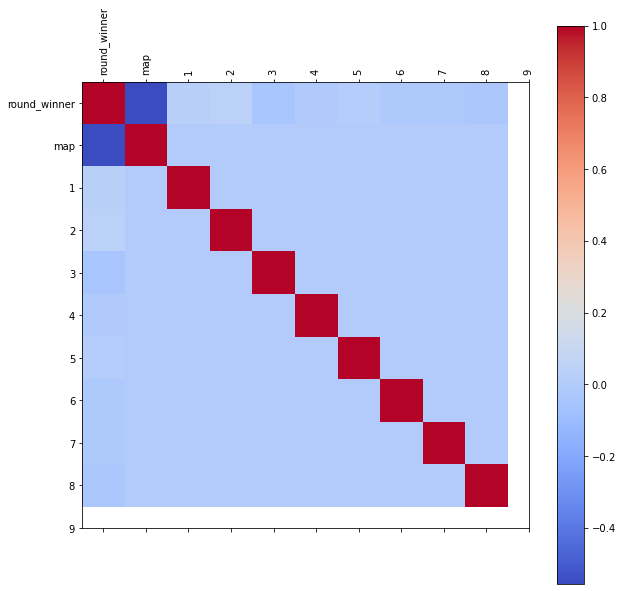

In [305]:
f = plt.figure(figsize=(10, 10))
plt.matshow(pca_weapcat_deltaa_df.corr(), fignum=f.number, cmap=plt.cm.coolwarm)
plt.xticks(range(pca_weapcat_deltaa_df.shape[1]), pca_weapcat_deltaa_df.columns, fontsize=10, rotation=90)
plt.yticks(range(pca_weapcat_deltaa_df.shape[1]), pca_weapcat_deltaa_df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

In [306]:
mi_pca = mutual_info_classif(df_map_pca.drop(["round_winner"], axis=1), df_map_pca.round_winner)
mi_pca_df = pd.DataFrame(mi_pca,index=df_map_pca.iloc[:,1:].columns, columns =['mi_score'])
mi_pca_df[mi_pca_df['mi_score']>0.05].sort_values(by='mi_score', ascending=False)

mi_score
2   0.147591
4   0.059628
27  0.053423
37  0.051379
20  0.050065

#### 14. Perform PCA from time left to players alive (19 variables) and for the grenades related variables

In [307]:
df_input = pd.concat([df.iloc[:,1], df.iloc[:,3:18], df.iloc[:,-10:-1]], axis = 1)
#df_input.head(2)
df_input.shape

(81999, 25)

In [308]:
X = df_input.values # We do not take the class label
X_std = StandardScaler().fit_transform(X) # normalizing the features

In [309]:
pca = PCA(0.9) #define percentage of variance that we want to explain

In [310]:
pca.fit(X_std) #fit the pca

PCA(n_components=0.9)

In [311]:
pca.n_components_ #show number of principal components created

12

In [312]:
df_pca = pca.transform(X_std) #create array with PC values

In [313]:
col = list(range(1,df_pca.shape[1]+1)) #create columns for the df
#col

In [314]:
principalDf = pd.DataFrame(data = df_pca
             , columns = col) #put the values of PC into a df
principalDf.head(2)

1         2         3         4         5         6         7   \
0  2.469621 -1.107291 -0.493323  0.125205 -0.464954 -1.298462 -0.246106   
1 -0.566232 -0.491342  3.801110  2.570728 -0.878749  0.103827 -0.270781   

         8         9         10        11        12  
0  0.304218  2.041543 -0.442240 -1.050633 -0.837832  
1 -0.814588  0.684117  0.049223 -0.131139  0.035344

In [315]:
pca.explained_variance_ratio_ #show the percentage of the variance explained by each PC

array([0.28482207, 0.14205367, 0.13187111, 0.07235659, 0.04525212,
       0.04012021, 0.03968836, 0.03718024, 0.03306962, 0.02701578,
       0.02544905, 0.02161083])

In [316]:
df.iloc[:,1:].corrwith(df.iloc[:, 0]).sort_values() #check the correlation between each PC and the target variable

ct_armor               -0.337673
ct_helmets             -0.309118
ct_defuse_kits         -0.292646
ct_grenade_flashbang   -0.256002
ct_players_alive       -0.217051
                          ...   
ct_weapon_m249               NaN
t_weapon_m249                NaN
ct_weapon_negev              NaN
ct_weapon_r8revolver         NaN
ct_weapon_sawedoff           NaN
Length: 95, dtype: float64

In [317]:
principalDf.iloc[:,1:].corrwith(df.iloc[:, 0]).abs().sort_values(ascending=False).sort_values(ascending=False) #check the correlation between each PC and the target variable

2     0.419589
10    0.229697
3     0.142142
5     0.107383
11    0.068631
4     0.060553
12    0.054665
8     0.042805
9     0.024312
7     0.008194
6     0.003629
dtype: float64

In [318]:
df_map_pca = pd.concat([df.iloc[:,0], principalDf.iloc[:,0:]], axis = 1)
df_map_pca.head()

round_winner         1         2         3         4         5         6  \
0             0  2.469621 -1.107291 -0.493323  0.125205 -0.464954 -1.298462   
1             1 -0.566232 -0.491342  3.801110  2.570728 -0.878749  0.103827   
2             1  4.431195  1.901332 -1.009377  1.302580 -0.615463  1.970845   
3             0  3.290019 -0.570876 -1.034269  0.751200  0.656797 -0.587579   
4             1 -1.525438  0.499136  1.344139 -0.862483  1.836169 -0.745468   

          7         8         9        10        11        12  
0 -0.246106  0.304218  2.041543 -0.442240 -1.050633 -0.837832  
1 -0.270781 -0.814588  0.684117  0.049223 -0.131139  0.035344  
2 -1.824906  2.602689 -1.685650 -0.202001 -0.785623  0.057985  
3  0.118257  0.037147 -0.327095 -0.094415 -0.053288  0.293207  
4  0.033162  0.804307 -0.834880 -0.406687  0.654053  0.662243

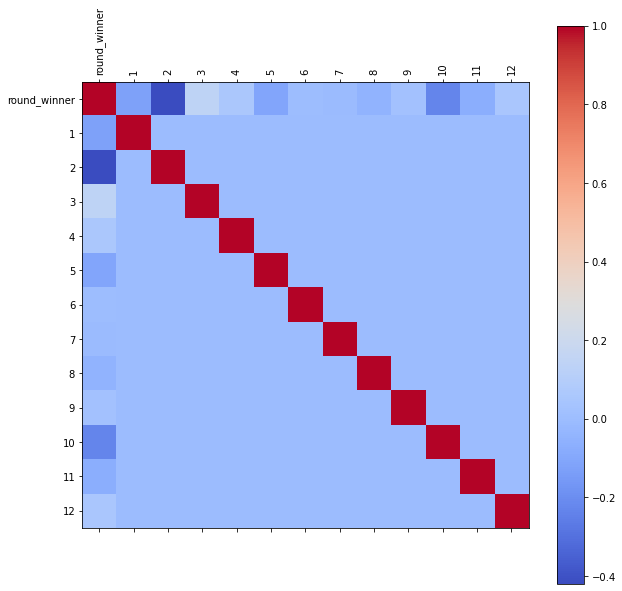

In [319]:
f = plt.figure(figsize=(10, 10))
plt.matshow(df_map_pca.corr(), fignum=f.number, cmap=plt.cm.coolwarm)
plt.xticks(range(df_map_pca.shape[1]), df_map_pca.columns, fontsize=10, rotation=90)
plt.yticks(range(df_map_pca.shape[1]), df_map_pca.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

In [320]:
mi_pca = mutual_info_classif(df_map_pca.drop(["round_winner"], axis=1), df_map_pca.round_winner)
mi_pca_df = pd.DataFrame(mi_pca,index=df_map_pca.iloc[:,1:].columns, columns =['mi_score'])
mi_pca_df[mi_pca_df['mi_score']>0.05].sort_values(by='mi_score', ascending=False)

mi_score
2   0.124399
7   0.117684
10  0.059451

### Transform categorical variables into dummy

In [321]:
# Create an one-hot encoder for map variables
# In order to transform categorical variables into dummy variables we used 'one-hot enconder'

ohe = OneHotEncoder()

df['map'] = df.map.astype('category')
categorical_cols = df.columns[df.dtypes=='category'].tolist()
hot_enc = pd.DataFrame(ohe.fit_transform(df[categorical_cols]).toarray(), columns=ohe.get_feature_names(categorical_cols)).reset_index(drop=True)

df = pd.concat([df, hot_enc], axis = 1)
df = df.drop(['map'], axis=1)

df.head(2)

round_winner  time_left  bomb_planted  ct_defuse_kits  \
0             0      94.96           0.0             4.0   
1             1     175.00           0.0             0.0   

   ct_grenade_flashbang  t_grenade_flashbang  ct_score  t_score  ct_health  \
0                   3.0                  5.0      11.0      2.0      392.0   
1                   0.0                  3.0      13.0      9.0      500.0   

   t_health  ...  ct_grenade_decoygrenade  t_grenade_decoygrenade  \
0     500.0  ...                      0.0                     1.0   
1     500.0  ...                      0.0                     0.0   

   map_de_cache  map_de_dust2  map_de_inferno  map_de_mirage  map_de_nuke  \
0           0.0           0.0             0.0            0.0          0.0   
1           0.0           0.0             0.0            0.0          1.0   

   map_de_overpass  map_de_train  map_de_vertigo  
0              0.0           1.0             0.0  
1              0.0           0.0             0.0  

[2 rows x 104 columns]

In [322]:
# In order to transform categorical variables into dummy variables we used 'one-hot enconder'

ohe = OneHotEncoder()

delta_df['map'] = delta_df.map.astype('category')
categorical_cols = delta_df.columns[delta_df.dtypes=='category'].tolist()
hot_enc = pd.DataFrame(ohe.fit_transform(delta_df[categorical_cols]).toarray(), columns=ohe.get_feature_names(categorical_cols)).reset_index(drop=True)

delta_df = pd.concat([delta_df, hot_enc], axis = 1)
delta_df = delta_df.drop(['map'], axis=1)

delta_df.head(2)

round_winner  time_left  bomb_planted  ct_defuse_kits  \
0             0      94.96           0.0             4.0   
1             1     175.00           0.0             0.0   

   delta_grenade_flashbang  delta_score  delta_health  delta_armor  \
0                     -2.0          9.0        -108.0       -121.0   
1                     -3.0          4.0           0.0       -300.0   

   delta_money  delta_helmets  ...  delta_grenade_decoygrenade  \
0      20800.0           -1.0  ...                        -1.0   
1     -16200.0           -4.0  ...                         0.0   

   delta_ta_grenade_flashbang  map_de_cache  map_de_dust2  map_de_inferno  \
0                       -11.0           0.0           0.0             0.0   
1                        -7.0           0.0           0.0             0.0   

   map_de_mirage  map_de_nuke  map_de_overpass  map_de_train  map_de_vertigo  
0            0.0          0.0              0.0           1.0             0.0  
1            0.0          1.0              0.0           0.0             0.0  

[2 rows x 59 columns]

In [323]:
# In order to transform categorical variables into dummy variables we used 'one-hot enconder'

ohe = OneHotEncoder()

weapcat_deltaa_df['map'] = weapcat_deltaa_df.map.astype('category')
categorical_cols = weapcat_deltaa_df.columns[weapcat_deltaa_df.dtypes=='category'].tolist()
hot_enc = pd.DataFrame(ohe.fit_transform(weapcat_deltaa_df[categorical_cols]).toarray(), columns=ohe.get_feature_names(categorical_cols)).reset_index(drop=True)

weapcat_deltaa_df = pd.concat([weapcat_deltaa_df, hot_enc], axis = 1)
weapcat_deltaa_df = weapcat_deltaa_df.drop(['map'], axis=1)

weapcat_deltaa_df.head(2)

round_winner  time_left  bomb_planted  ct_defuse_kits  delta_score  \
0             0      94.96           0.0             4.0          9.0   
1             1     175.00           0.0             0.0          4.0   

   delta_health  delta_armor  delta_money  delta_helmets  delta_players_alive  \
0        -108.0       -121.0      20800.0           -1.0                 -1.0   
1           0.0       -300.0     -16200.0           -4.0                  0.0   

   ...  dlt_SMGs  dlt_Grenade  map_de_cache  map_de_dust2  map_de_inferno  \
0  ... -0.142857    -1.333333           0.0           0.0             0.0   
1  ...  0.000000    -1.166667           0.0           0.0             0.0   

   map_de_mirage  map_de_nuke  map_de_overpass  map_de_train  map_de_vertigo  
0            0.0          0.0              0.0           1.0             0.0  
1            0.0          1.0              0.0           0.0             0.0  

[2 rows x 24 columns]

In [324]:
# In order to transform categorical variables into dummy variables we used 'one-hot enconder'

ohe = OneHotEncoder()

pca_weapcat_deltaa_df['map'] = pca_weapcat_deltaa_df.map.astype('category')
categorical_cols = pca_weapcat_deltaa_df.columns[pca_weapcat_deltaa_df.dtypes=='category'].tolist()
hot_enc = pd.DataFrame(ohe.fit_transform(pca_weapcat_deltaa_df[categorical_cols]).toarray(), columns=ohe.get_feature_names(categorical_cols)).reset_index(drop=True)

pca_weapcat_deltaa_df = pd.concat([pca_weapcat_deltaa_df, hot_enc], axis = 1)
pca_weapcat_deltaa_df = pca_weapcat_deltaa_df.drop(['map'], axis=1)

## Output of 3. Transformation:

After the different analysis and transformations performed, we obtained 4 main dataset to test with the different models:

- **Original one 'df'**: All the original columns with map column with hot-encoder (Number of features = 104)
  
- **Deltas 'delta_df'**: Columns round winner,  time_left, map (encoded), bomb planted, ct_defuse_kits. Plus the delta columns (Number of features = 59)
  
- **Variable groups by category of guns 'weapcat_deltaa_df'**: Takes the weapon and grenade related variables, grouped them by category (rifle, pistol, etc), calculate de average and then calculate the difference between ct and t columns. Concatenated with the variables that are not weapon related (Number of features = 24)
  
- **Weapons category grouped + deltas + PCA 'pca_weapcat_deltaa_df'**: Standarize the weapcat_deltaa_df dataframe and run PCA analysis (Number of features = 18)

**Original one 'df'**

In [325]:
df.shape

(81999, 104)

In [326]:
df.head()

round_winner  time_left  bomb_planted  ct_defuse_kits  \
0             0      94.96           0.0             4.0   
1             1     175.00           0.0             0.0   
2             1     175.00           0.0             3.0   
3             0      74.89           0.0             4.0   
4             1     110.04           0.0             0.0   

   ct_grenade_flashbang  t_grenade_flashbang  ct_score  t_score  ct_health  \
0                   3.0                  5.0      11.0      2.0      392.0   
1                   0.0                  3.0      13.0      9.0      500.0   
2                   5.0                  3.0      14.0     11.0      500.0   
3                   4.0                  4.0      12.0     11.0      439.0   
4                   0.0                  0.0       3.0     12.0      500.0   

   t_health  ...  ct_grenade_decoygrenade  t_grenade_decoygrenade  \
0     500.0  ...                      0.0                     1.0   
1     500.0  ...                      0.0                     0.0   
2     500.0  ...                      0.0                     0.0   
3     489.0  ...                      0.0                     0.0   
4     500.0  ...                      0.0                     1.0   

   map_de_cache  map_de_dust2  map_de_inferno  map_de_mirage  map_de_nuke  \
0           0.0           0.0             0.0            0.0          0.0   
1           0.0           0.0             0.0            0.0          1.0   
2           0.0           0.0             1.0            0.0          0.0   
3           0.0           0.0             1.0            0.0          0.0   
4           0.0           0.0             0.0            0.0          1.0   

   map_de_overpass  map_de_train  map_de_vertigo  
0              0.0           1.0             0.0  
1              0.0           0.0             0.0  
2              0.0           0.0             0.0  
3              0.0           0.0             0.0  
4              0.0           0.0             0.0  

[5 rows x 104 columns]

**Deltas 'delta_df'**

In [327]:
delta_df.shape

(81999, 59)

In [328]:
delta_df.head()

round_winner  time_left  bomb_planted  ct_defuse_kits  \
0             0      94.96           0.0             4.0   
1             1     175.00           0.0             0.0   
2             1     175.00           0.0             3.0   
3             0      74.89           0.0             4.0   
4             1     110.04           0.0             0.0   

   delta_grenade_flashbang  delta_score  delta_health  delta_armor  \
0                     -2.0          9.0        -108.0       -121.0   
1                     -3.0          4.0           0.0       -300.0   
2                      2.0          3.0           0.0        198.0   
3                      0.0          1.0         -50.0          9.0   
4                      0.0         -9.0           0.0        100.0   

   delta_money  delta_helmets  ...  delta_grenade_decoygrenade  \
0      20800.0           -1.0  ...                        -1.0   
1     -16200.0           -4.0  ...                         0.0   
2       4400.0            2.0  ...                         0.0   
3      -5650.0           -2.0  ...                         0.0   
4         50.0            0.0  ...                        -1.0   

   delta_ta_grenade_flashbang  map_de_cache  map_de_dust2  map_de_inferno  \
0                       -11.0           0.0           0.0             0.0   
1                        -7.0           0.0           0.0             0.0   
2                        -1.0           0.0           0.0             1.0   
3                        -1.0           0.0           0.0             1.0   
4                         9.0           0.0           0.0             0.0   

   map_de_mirage  map_de_nuke  map_de_overpass  map_de_train  map_de_vertigo  
0            0.0          0.0              0.0           1.0             0.0  
1            0.0          1.0              0.0           0.0             0.0  
2            0.0          0.0              0.0           0.0             0.0  
3            0.0          0.0              0.0           0.0             0.0  
4            0.0          1.0              0.0           0.0             0.0  

[5 rows x 59 columns]

**Variable groups by category of guns 'weapcat_deltaa_df'**

In [329]:
weapcat_deltaa_df.shape

(81999, 24)

In [330]:
weapcat_deltaa_df.head()

round_winner  time_left  bomb_planted  ct_defuse_kits  delta_score  \
0             0      94.96           0.0             4.0          9.0   
1             1     175.00           0.0             0.0          4.0   
2             1     175.00           0.0             3.0          3.0   
3             0      74.89           0.0             4.0          1.0   
4             1     110.04           0.0             0.0         -9.0   

   delta_health  delta_armor  delta_money  delta_helmets  delta_players_alive  \
0        -108.0       -121.0      20800.0           -1.0                 -1.0   
1           0.0       -300.0     -16200.0           -4.0                  0.0   
2           0.0        198.0       4400.0            2.0                  0.0   
3         -50.0          9.0      -5650.0           -2.0                  0.0   
4           0.0        100.0         50.0            0.0                  0.0   

   ...  dlt_SMGs  dlt_Grenade  map_de_cache  map_de_dust2  map_de_inferno  \
0  ... -0.142857    -1.333333           0.0           0.0             0.0   
1  ...  0.000000    -1.166667           0.0           0.0             0.0   
2  ...  0.000000     1.500000           0.0           0.0             1.0   
3  ...  0.142857     0.333333           0.0           0.0             1.0   
4  ...  0.000000    -0.333333           0.0           0.0             0.0   

   map_de_mirage  map_de_nuke  map_de_overpass  map_de_train  map_de_vertigo  
0            0.0          0.0              0.0           1.0             0.0  
1            0.0          1.0              0.0           0.0             0.0  
2            0.0          0.0              0.0           0.0             0.0  
3            0.0          0.0              0.0           0.0             0.0  
4            0.0          1.0              0.0           0.0             0.0  

[5 rows x 24 columns]

**Weapons category grouped + deltas + PCA 'pca_weapcat_deltaa_df'**

In [331]:
pca_weapcat_deltaa_df.shape

(81999, 18)

In [332]:
pca_weapcat_deltaa_df.head()

round_winner         1         2         3         4         5         6  \
0             0 -0.875844  1.954449 -0.182192 -3.124494 -0.111512  0.736495   
1             1 -2.403883 -1.479000 -1.137174 -0.898227  0.335677  0.051889   
2             1  1.999035  1.418612 -1.317993 -0.156249 -0.234065  0.111264   
3             0  0.025854  0.604020 -0.006717  0.287220  0.426861  0.228310   
4             1 -0.296898 -0.845180 -0.553591  1.143970 -0.469825 -0.439320   

          7         8         9  map_de_cache  map_de_dust2  map_de_inferno  \
0  0.129565 -0.212895  0.695281           0.0           0.0             0.0   
1 -1.020288  0.900644  0.572395           0.0           0.0             0.0   
2  0.152276  0.454759 -0.030400           0.0           0.0             1.0   
3 -0.981131 -1.411823  0.845528           0.0           0.0             1.0   
4  0.674782 -0.355674 -1.365515           0.0           0.0             0.0   

   map_de_mirage  map_de_nuke  map_de_overpass  map_de_train  map_de_vertigo  
0            0.0          0.0              0.0           1.0             0.0  
1            0.0          1.0              0.0           0.0             0.0  
2            0.0          0.0              0.0           0.0             0.0  
3            0.0          0.0              0.0           0.0             0.0  
4            0.0          1.0              0.0           0.0             0.0

# 4. Model data

To vary quickly the analysed dataset:

In [335]:
# Uncomment the desired dataset for modelling:


# df_mod = df.copy()   
# df_mod = delta_df.copy()
# df_mod = weapcat_deltaa_df.copy()
# df_mod = pca_weapcat_deltaa_df.copy()

## Testing dataset: df = delta_df

In [ ]:
# Uncomment the desired dataset for modelling:

# df_mod = df.copy()
df_mod = delta_df.copy()
# df_mod = weapcat_deltaa_df.copy()
# df_mod = pca_weapcat_deltaa_df.copy()

In [338]:
# Define the function to split the dataset into train-test 
from sklearn.model_selection import train_test_split

def split_df(dataframe, seed=None, percentage=0.7):
    
    X = dataframe.loc[:, dataframe.columns != 'round_winner']
    y = dataframe['round_winner']

    return train_test_split(X, y, test_size=1-percentage, random_state=42)

In [339]:
# Before starting we split the dataset

X_train, X_test, y_train, y_test = split_df(df_mod)

## Testing dataset: df = weapcat_deltaa_df

In [ ]:
# Uncomment the desired dataset for modelling:

# df_mod = df.copy()
# df_mod = delta_df.copy()
df_mod = weapcat_deltaa_df.copy()
# df_mod = pca_weapcat_deltaa_df.copy()

In [338]:
# Define the function to split the dataset into train-test 
from sklearn.model_selection import train_test_split

def split_df(dataframe, seed=None, percentage=0.7):
    
    X = dataframe.loc[:, dataframe.columns != 'round_winner']
    y = dataframe['round_winner']

    return train_test_split(X, y, test_size=1-percentage, random_state=42)

In [339]:
# Before starting we split the dataset

X_train, X_test, y_train, y_test = split_df(df_mod)

## Testing dataset: df = pca_weapcat_deltaa_df

In [387]:
# Uncomment the desired dataset for modelling:


# df_mod = df.copy() 
# df_mod = delta_df.copy()
# df_mod = weapcat_deltaa_df.copy()
df_mod = pca_weapcat_deltaa_df.copy()

In [338]:
# Define the function to split the dataset into train-test 
from sklearn.model_selection import train_test_split

def split_df(dataframe, seed=None, percentage=0.7):
    
    X = dataframe.loc[:, dataframe.columns != 'round_winner']
    y = dataframe['round_winner']

    return train_test_split(X, y, test_size=1-percentage, random_state=42)

In [339]:
# Before starting we split the dataset

X_train, X_test, y_train, y_test = split_df(df_mod)

### Logistic regression model

In [337]:
# Specific libraries for the modelling

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score,plot_confusion_matrix

**Pure logistic regression**

In [340]:
# Linear regression model evaluation

def cv_model_evaluation(X_train, y_train, X_val, y_val, X_test, y_test):

    model = linear_model.LogisticRegression(max_iter=100, n_jobs= 4)
    model.fit(X_train, y_train) ## model fit is done with train data

    # The predicted probabilities given to each sample in the test set. `predict_proba` gives you the probabilities of both classes, we take the probs of class 1 for simplicity.
    probs = model.predict_proba(X_val)[:,1] # ":" means all the rows ## we calculate the probs with the validation data

    # Predictions over the validations set to compute the optimal threshold ## as if the opt.threshold would be a hyperparameter
    cv_predictions = pd.DataFrame({'round_winner':y_val, 'pred':probs}) ## uses a dictionary (key,value) to create the dataframe with 2 columns "real" and "predict_proba"
    fpr, tpr, thresholds = roc_curve(cv_predictions.round_winner, cv_predictions.pred)
    
    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # Accuracy Score computed over the test set
    probs = model.predict_proba(X_test)[:,1]
    test_predictions = pd.DataFrame({'round_winner':y_test, 'pred':probs}) ## he gets the accuracy with the test set
    
    return accuracy_score(y_test, [pred>optimal_threshold for pred in test_predictions.pred]) ## accuracy_score(observed values, predicted values) 

In [347]:
# K-fold Cross Validation with 100 iterations

from sklearn.model_selection import KFold

kfold_cv_perf = []
num_iterations = 100

for i in range(1,num_iterations):
    X, X_test, y, y_test = split_df(df, percentage=0.8)

    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    fold_perf = []
    for train_index, val_index in cv.split(X):
        X_train, X_val, y_train, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
        fold_perf.append(cv_model_evaluation(X_train, y_train, X_val, y_val, X_test, y_test))
    kfold_cv_perf.append(np.mean(fold_perf))
    
index_of_max_performance = np.argmax(kfold_cv_perf)
max_perf = kfold_cv_perf[index_of_max_performance]

index_of_min_performance = np.argmin(kfold_cv_perf)
min_perf = kfold_cv_perf[index_of_min_performance]
    
print("Max perfomance accuracy = {}".format(max_perf))

Max perfomance accuracy = 0.7464756097560976


In [351]:
# # Plotting the performance 

# plt.figure(figsize=(10,10))
# plt.title("Linear Regression with CV", fontsize=20)
# plt.boxplot([kfold_cv_perf])

**Logistic regression with cross-validation and 'Ridge' regularization**

In [343]:
# Ridge
from sklearn.feature_selection import SelectFromModel

# Setting different parameters to test
alphas = 10**np.linspace(-1,-4,100)

ridge_mod_cv = linear_model.LogisticRegressionCV(max_iter=100,penalty='l2',Cs=alphas).fit(X_train, y_train)

Accuracy = 0.7446


C:\Users\nicol\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


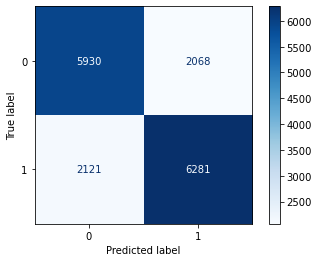

In [344]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ridge_mod_cv.predict(X_test))))
plot_confusion_matrix(ridge_mod_cv, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

**Logistic regression with cross-validation and 'Lasso' Regularization**

In [345]:
# Lasso
from sklearn.feature_selection import SelectFromModel

lasso_mod_cv = linear_model.LogisticRegressionCV(max_iter=100,penalty='l1',solver='liblinear',Cs=alphas).fit(X_train, y_train)

Accuracy = 0.7445


C:\Users\nicol\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


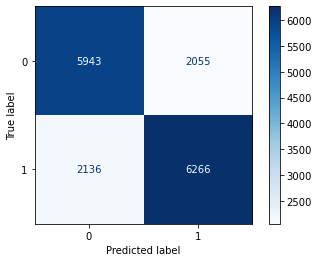

In [346]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,lasso_mod_cv.predict(X_test))))
plot_confusion_matrix(lasso_mod_cv, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

### Decision Tree Classifier model

**One decision tree**

In [388]:
X_train, X_test, y_train, y_test = split_df(df)

In [389]:
from sklearn.tree import DecisionTreeClassifier

df_treec = DecisionTreeClassifier(random_state=42)
df_treec.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [390]:
# Visualize the tree

# dot_data = StringIO()
# export_graphviz(df_treec, out_file=dot_data, feature_names=X_train.columns,
#                 filled=True, rounded=True,special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

Accuracy = 0.7296


C:\Users\nicol\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


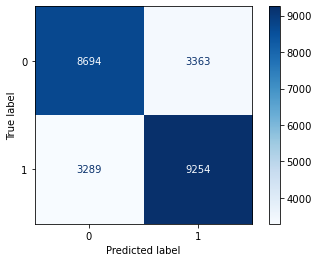

In [391]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score

predictions = df_treec.predict(X_test)

print("Accuracy = {0:.4f}".format(accuracy_score(y_test,df_treec.predict(X_test))))
plot_confusion_matrix(df_treec, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

In [392]:
# Casting the columns into string before ploting

X_train.columns = X_train.columns.map(str)

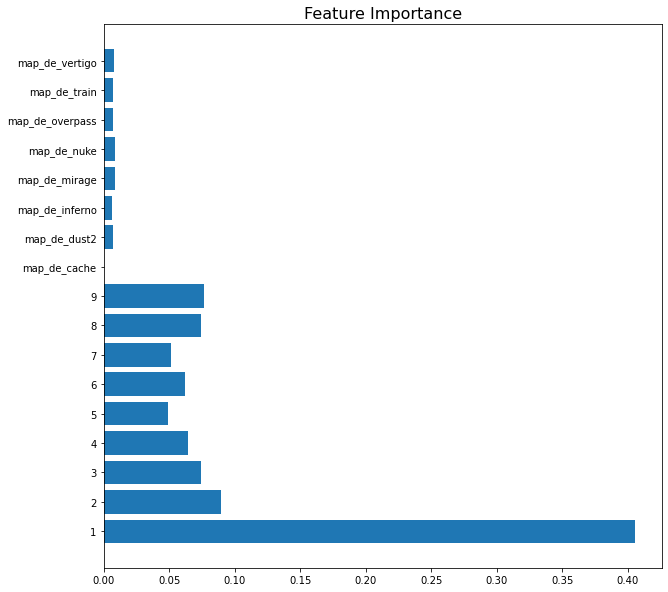

In [393]:
# Plotting the feature importance

plt.figure(figsize=(10,10))
plt.barh(X_train.columns, df_treec.feature_importances_)
plt.title('Feature Importance', fontsize=16);

Now we will try to improve the accuracy fine-tuning the hyperparameters with GridSearch

In [394]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': range(1,16)}

df_treec_pruned_cv = GridSearchCV(df_treec, 
                   param_grid,
                   scoring='accuracy',
                   cv=10 , n_jobs= 4, verbose=1)

df_treec_pruned_cv.fit(X_train,y_train)
print("Best parameters set found on development set:")
print()
print(df_treec_pruned_cv.best_params_)
print()
print("Grid scores on development set:")
print()
means = df_treec_pruned_cv.cv_results_['mean_test_score']
stds = df_treec_pruned_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, df_treec_pruned_cv.cv_results_['params']):
    print("Accuracy = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   23.4s finished


Best parameters set found on development set:

{'max_depth': 7}

Grid scores on development set:

Accuracy = 0.740 (+/0.009) for {'max_depth': 1}
Accuracy = 0.740 (+/0.009) for {'max_depth': 2}
Accuracy = 0.740 (+/0.009) for {'max_depth': 3}
Accuracy = 0.743 (+/0.010) for {'max_depth': 4}
Accuracy = 0.745 (+/0.013) for {'max_depth': 5}
Accuracy = 0.746 (+/0.011) for {'max_depth': 6}
Accuracy = 0.748 (+/0.010) for {'max_depth': 7}
Accuracy = 0.745 (+/0.013) for {'max_depth': 8}
Accuracy = 0.745 (+/0.011) for {'max_depth': 9}
Accuracy = 0.744 (+/0.010) for {'max_depth': 10}
Accuracy = 0.743 (+/0.011) for {'max_depth': 11}
Accuracy = 0.741 (+/0.011) for {'max_depth': 12}
Accuracy = 0.739 (+/0.011) for {'max_depth': 13}
Accuracy = 0.737 (+/0.012) for {'max_depth': 14}
Accuracy = 0.735 (+/0.009) for {'max_depth': 15}


Text(0, 0.5, 'Accuracy')

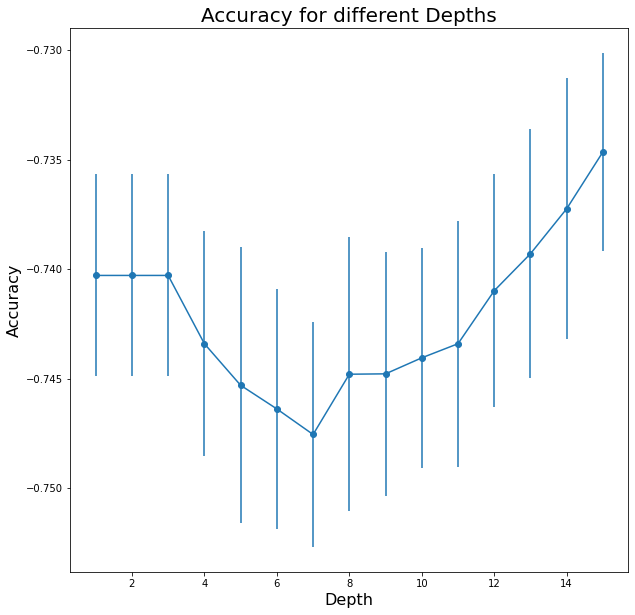

In [395]:
plt.figure(figsize=(10,10))
plt.errorbar(range(1,16,1), [-m for m in means], yerr=stds, fmt='-o')
plt.title('Accuracy for different Depths', fontsize=20)
plt.xlabel("Depth", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)

In [396]:
df_treec_pruned = DecisionTreeClassifier(random_state=42, max_depth=7)
df_treec_pruned.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, random_state=42)

Accuracy = 0.7478


C:\Users\nicol\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


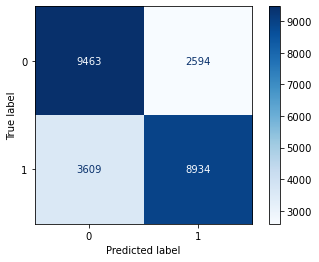

In [397]:
predictions = df_treec_pruned.predict(X_test)
print("Accuracy = {0:.4f}".format(accuracy_score(y_test, predictions)))
plot_confusion_matrix(df_treec_pruned, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

**Bagging**

In [398]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

mod_bagging = RandomForestRegressor(random_state=42, max_features=len(X_train.columns))
mod_bagging.fit(X_train, y_train)
predictions = mod_bagging.predict(X_test)
print("MSE = {0:.4f}".format(mean_squared_error(y_test, predictions)))

MSE = 0.1407


Accuracy = 0.7908


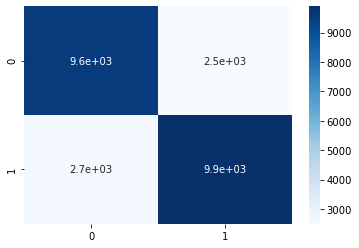

In [407]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn

predictions = mod_bagging.predict(X_test)

threshold = 0.5
cm = confusion_matrix(y_test, [pred>threshold for pred in predictions])
sn.heatmap(cm, annot=True, cmap=plt.cm.Blues)

print("Accuracy = {0:.4f}".format(accuracy_score(y_test, [pred>threshold for pred in predictions])))

In [408]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression

In [409]:
dtc = DecisionTreeClassifier(criterion="entropy")
bag_model=BaggingClassifier(base_estimator=dtc, n_estimators=100, bootstrap=True)
bag_model=bag_model.fit(X_train,y_train)

0.7902032520325203


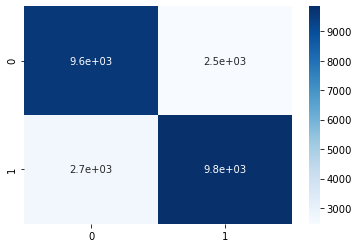

In [410]:
y_test_pred=bag_model.predict(X_test)

print(bag_model.score(X_test, y_test))

# print(confusion_matrix(y_test, y_test_pred)) 

sn.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, cmap=plt.cm.Blues)

**Random Forest Regressor + Threshold for classification**

In [411]:
from sklearn.ensemble import RandomForestRegressor

mod_bagging = RandomForestRegressor(random_state=42, max_features='sqrt')
mod_bagging.fit(X_train, y_train)
predictions = mod_bagging.predict(X_test)
print("MSE = {0:.4f}".format(mean_squared_error(y_test, predictions)))

MSE = 0.1372


Accuracy = 0.7961


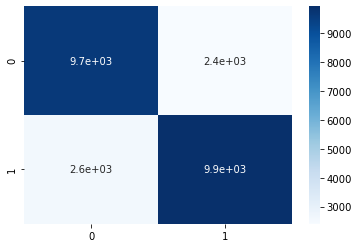

In [412]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn

predictions = mod_bagging.predict(X_test)

threshold = 0.5
cm = confusion_matrix(y_test, [pred>threshold for pred in predictions])
sn.heatmap(cm, annot=True, cmap=plt.cm.Blues)


print("Accuracy = {0:.4f}".format(accuracy_score(y_test, [pred>threshold for pred in predictions])))
#plot_confusion_matrix(mod_bagging, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

**Random Forest Classifier**

In [413]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [414]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7966666666666666


**Randomised search CV**

In [415]:
# import random search, random forest, iris data, and distributions
from sklearn.model_selection import RandomizedSearchCV
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, truncnorm, randint

In [416]:
#Setting model parameters

model_params = {
    # randomly sample numbers from 4 to 204 estimators
    'n_estimators': randint(4,200),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    'min_samples_split': uniform(0.01, 0.199)
}

First try: not finished

In [ ]:
#number of trees
n_estimators = [500, 800, 1500, 2500, 5000]
#max number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
#max number of levels in tree
max_depth = [10, 20, 30, 40, 50]
max_depth.append(None)
#minimum number of samples required to split a node
min_sample_split = [2, 5, 10, 15, 20]
#minimum number of samples required at each leaf node
min_sample_leaf = [1,2,4,5,10,20,30,40,80,100]

Second try: accuracy 0.84 on df2

In [1]:
#number of trees
n_estimators = [100, 200, 500, 800, 1500]
#max number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
#max number of levels in tree
max_depth = [10, 20, 30, 40, 50]
max_depth.append(None)
#minimum number of samples required to split a node
min_sample_split = [2, 5, 10, 15, 20]
#minimum number of samples required at each leaf node
min_sample_leaf = [1,2,4,5,10,20,30,40,80,100]

Third try: not run yet

In [ ]:
#number of trees
n_estimators = [700, 800, 900, 1000, 1200]
#max number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
#max number of levels in tree
max_depth = [30, 40, 50, 60, 80]
max_depth.append(None)
#minimum number of samples required to split a node
min_sample_split = [1, 2, 3, 4, 5]
#minimum number of samples required at each leaf node
min_sample_leaf = [1,2,4]

Save the parameters (to be run before running the next cell)

In [ ]:
model_params = {
    
    'n_estimators': n_estimators,

    'max_features': max_features,
    
    'max_depth': max_depth,
    
    'min_samples_split': min_sample_split,
    
}

Run the search with random forest

In [417]:
# create random forest classifier model
rf_model = RandomForestClassifier()

# set up random search meta-estimator
# this will train 100 models over 5 folds of cross validation (500 models total)
clf = RandomizedSearchCV(rf_model, model_params, n_iter=100, cv=5, random_state=1)

# train the random search meta-estimator to find the best model out of 100 candidates
model = clf.fit(X_train, y_train)

# print winning set of hyperparameters
from pprint import pprint
pprint(model.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': array([0.26065304]),
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 0.013956146634119322,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 105,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [418]:
# generate predictions using the best-performing model
predictions = model.predict(X_test)
#print(predictions)
print("Accuracy:",metrics.accuracy_score(y_test, predictions))

Accuracy: 0.7523170731707317


#### XGBoost model

In [ ]:
import xgboost
from sklearn.metrics import plot_confusion_matrix, accuracy_score

xgb_tree = xgboost.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_tree.fit(X_train, y_train)
predictions = xgb_tree.predict(X_test)

print("Accuracy = {0:.4f}".format(accuracy_score(y_test,xgb_tree.predict(X_test))))
plot_confusion_matrix(xgb_tree, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues);

In [ ]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_tree, param_distributions=params, random_state=42, n_iter=200, cv=5, verbose=1, n_jobs= 4, return_train_score=True)
search.fit(X_train, y_train)

In [ ]:
print("Best parameters set found on development set:")
print()
print(search.best_params_)
print()
print("Grid scores on development set:")
print()
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search.cv_results_['params']):
    print("MSE = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

In [ ]:
predictions = search.best_estimator_.predict(X_test)

print("Accuracy = {0:.4f}".format(accuracy_score(y_test,search.best_estimator_.predict(X_test))))
plot_confusion_matrix(search.best_estimator_, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

### Support Vector Machines (SVM) model 

Sklearn documentation: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py

We will test 2 SVM models using different kernels: 'rbf' and 'poly', then we will use GridSearchCV and RandomizedSearchCV for optimizing the hyperparameters

In [422]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

**SVM**

In [423]:
# Using 'GridSearch' for tuning the most relevant hyperparameters of the SVM model kernel = rbf

from sklearn.model_selection import GridSearchCV
 
param_grid = {"C":[1,5,10,50,100], "gamma":[0.1,0.01,0.001,0.0001]}
n_iter_search = 20

estimator = RandomizedSearchCV(svm.SVC(), param_distributions=param_grid, cv=5, n_iter=n_iter_search)
estimator.fit(X_train, y_train).set_params(n_jobs= 4);

print("The best parameters are %s with a score of %0.5f"
      % (estimator.best_params_, estimator.best_score_))

scores = estimator.cv_results_['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['gamma']))

The best parameters are {'gamma': 0.1, 'C': 50} with a score of 0.76412


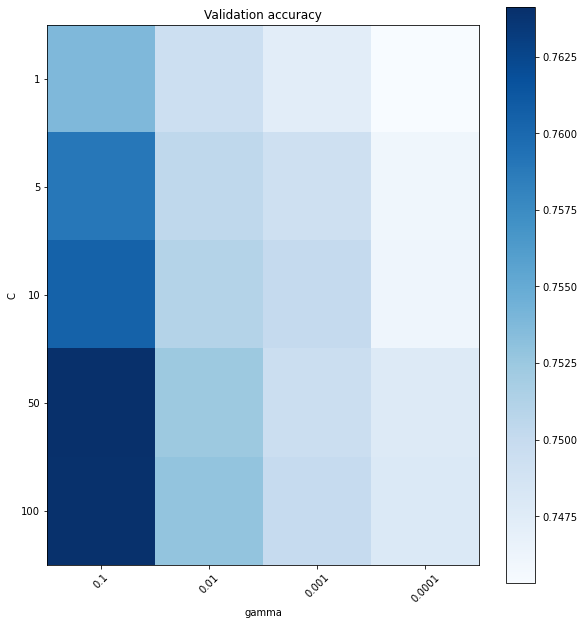

In [424]:
# Draw heatmap of the validation accuracy as a function of gamma and C

plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.Blues)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.title('Validation accuracy')
plt.show()

**SVM with 'rbf' kernel**

In [ ]:
# Using 'GridSearch' for tuning the most relevant hyperparameters of the SVM model kernel = rbf

from sklearn.model_selection import GridSearchCV
 
param_grid = {"C":[1,5,10,50,100], "gamma":[0.1,0.01,0.001,0.0001]}

estimator = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5)
estimator.fit(X_train, y_train).set_params(n_jobs= 4);

print("The best parameters are %s with a score of %0.4f"
      % (estimator.best_params_, estimator.best_score_))

scores = estimator.cv_results_['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['gamma']))

In [ ]:
# Draw heatmap of the validation accuracy as a function of gamma and C

plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.Blues)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.title('Validation accuracy')
plt.show()

**SVM with 'polynomial' kernel**

In [ ]:
# Using 'GridSearch' for tuning the most relevant hyperparameters of the SVM model with kernel = poly

from sklearn.model_selection import GridSearchCV
 
param_grid = {"C":[1,5,10,50,100], "gamma":[0.1,0.01,0.0001]}

estimator = GridSearchCV(svm.SVC(kernel='poly'), param_grid, cv=5)
estimator.fit(X_train, y_train).set_params(n_jobs= 4);

print("The best parameters are %s with a score of %0.4f"
      % (estimator.best_params_, estimator.best_score_))

scores = estimator.cv_results_['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['gamma']))

In [ ]:
# Draw heatmap of the validation accuracy as a function of gamma and C

plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.Blues)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.title('Validation accuracy')
plt.show()